# **Abstract:**
This dataset contains information regarding the different parameters that affect the CO2 Emissions of various vehicle models. 

Aim:
In this assignment we aim to create a complete ML project with

Checking Data Quality

Feature Selection

Modeling - Training Models, Selecting Best Model, Hyperparameter Tuning

Model Interpretibility

Reports and Visualizations

In [53]:
!pip install h2o
!pip install shap
!pip install lime
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

from sklearn.model_selection import train_test_split
import seaborn as sns


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Reading the data**

In [54]:
data = pd.read_csv('https://raw.githubusercontent.com/RyanJacobs4/DSEM-Dataset/main/FuelConsumption.csv')
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model Year                         946 non-null    int64  
 1   Make                               946 non-null    object 
 2   Model                              946 non-null    object 
 3   Vehicle Class                      946 non-null    object 
 4   Engine Size(L)                     946 non-null    float64
 5   Cylinders                          946 non-null    int64  
 6   Transmission                       946 non-null    object 
 7   Fuel Type                          946 non-null    object 
 8   Fuel Consumption (City (L/100 km)  946 non-null    float64
 9   Fuel Consumption(Hwy (L/100 km))   946 non-null    float64
 10  Fuel Consumption(Comb (L/100 km))  946 non-null    float64
 11  Fuel Consumption(Comb (mpg))       946 non-null    int64  

# **QQ Plot:**

<Figure size 800x500 with 0 Axes>

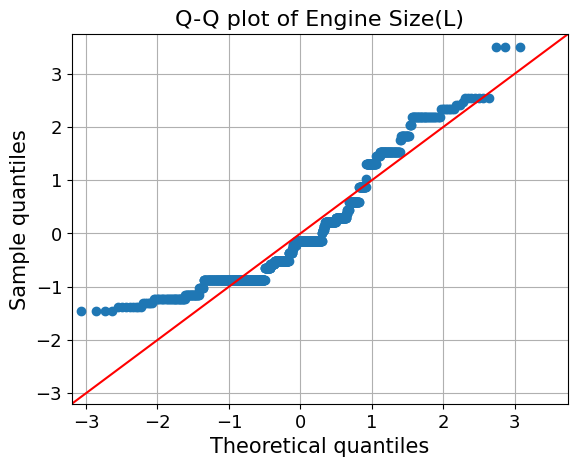

<Figure size 800x500 with 0 Axes>

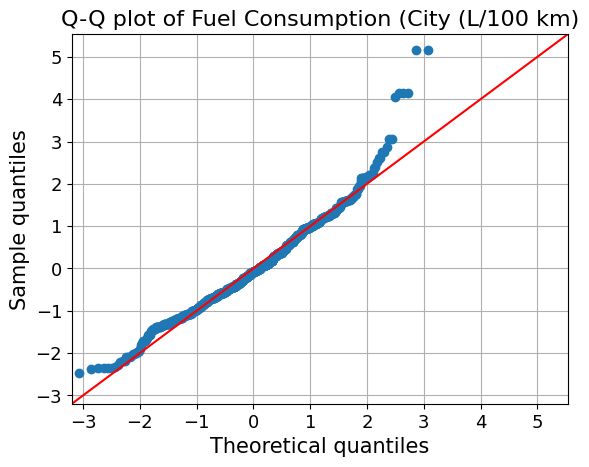

<Figure size 800x500 with 0 Axes>

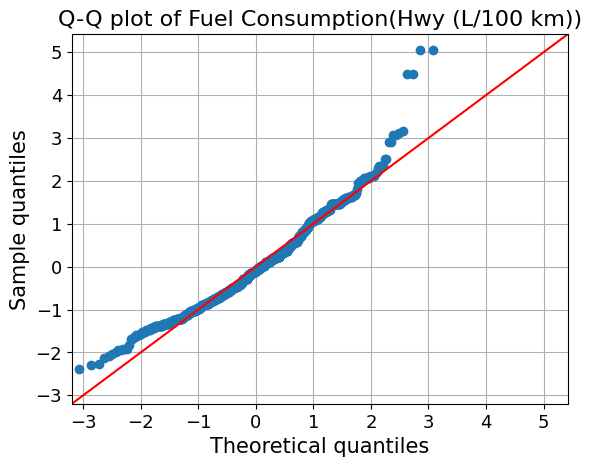

<Figure size 800x500 with 0 Axes>

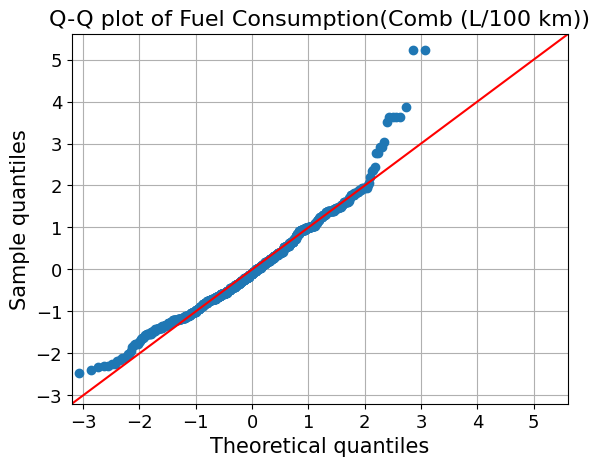

<Figure size 800x500 with 0 Axes>

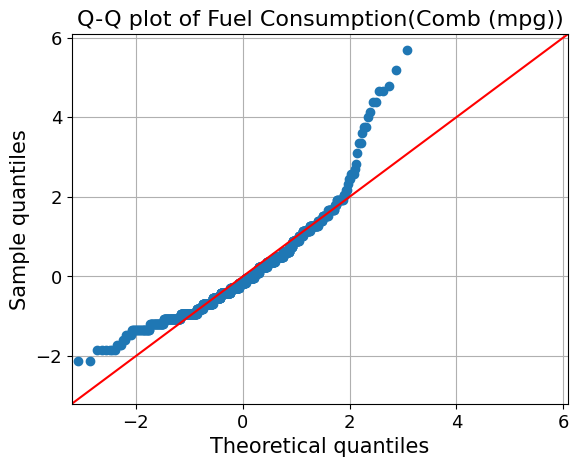

In [55]:
from statsmodels.graphics.gofplots import qqplot
data_norm=data[['Engine Size(L)','Fuel Consumption (City (L/100 km)','Fuel Consumption(Hwy (L/100 km))','Fuel Consumption(Comb (L/100 km))','Fuel Consumption(Comb (mpg))']]
for c in data_norm.columns[:]:
  plt.figure(figsize=(8,5))
  fig=qqplot(data_norm[c],line='45',fit='True')
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.xlabel("Theoretical quantiles",fontsize=15)
  plt.ylabel("Sample quantiles",fontsize=15)
  plt.title("Q-Q plot of {}".format(c),fontsize=16)
  plt.grid(True)
  plt.show()

A QQ plot allows you to visually compare the distribution of your data to a theoretical distribution and assess how closely your data follows that distribution. The closer the points on the QQ plot are to a straight line, the more closely your data follows the theoretical distribution.

# **Data Normalization:**

In [56]:
data.isnull().sum()
data = pd.get_dummies(data, columns = ['Vehicle Class', 'Fuel Type'])
transmissions_dict = {'AS8': 0, 'A8': 1, 'AS10': 2, 'A10': 3, 'M6': 4, 'AM7': 5, 'A9': 6, 'AM8': 7, 'AV': 8, 'AS6': 9, 'A6': 10, 'AV8': 11, 'AS9': 12, 'M7': 13, 'AV7': 14, 'AM6': 15, 'AV6': 16, 'AV10': 17, 'AS7': 18, 'M5': 19, 'AV1': 20, 'AS5': 21, 'A7': 22}
data = data.drop(['Make', 'Model'], axis = 1)

data.Transmission = [transmissions_dict[item] for item in data.Transmission]
data['Transmission']

0      7
1      2
2      2
3      2
4      2
      ..
941    0
942    0
943    0
944    0
945    0
Name: Transmission, Length: 946, dtype: int64

<Axes: >

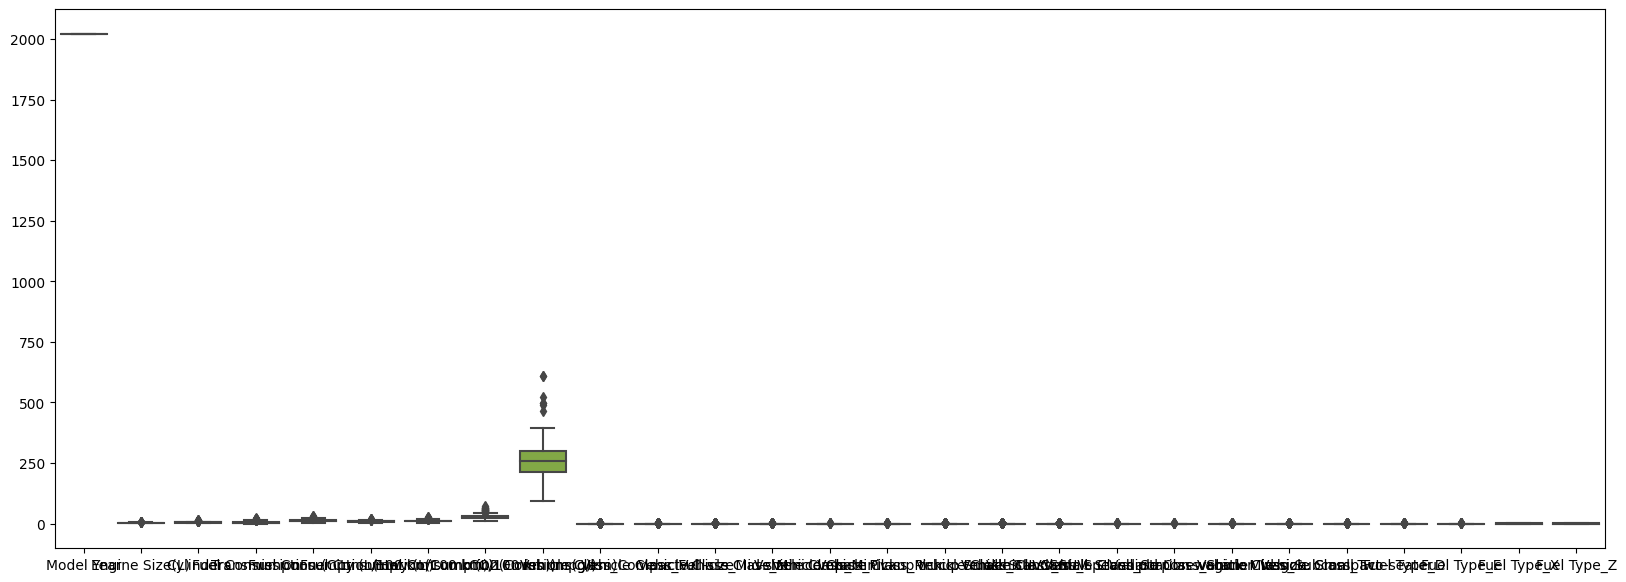

In [57]:
#Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(20,7))
sns.boxplot(data=data)

Normalising the data for model column beacuse the value is too high when compared to other independent variable

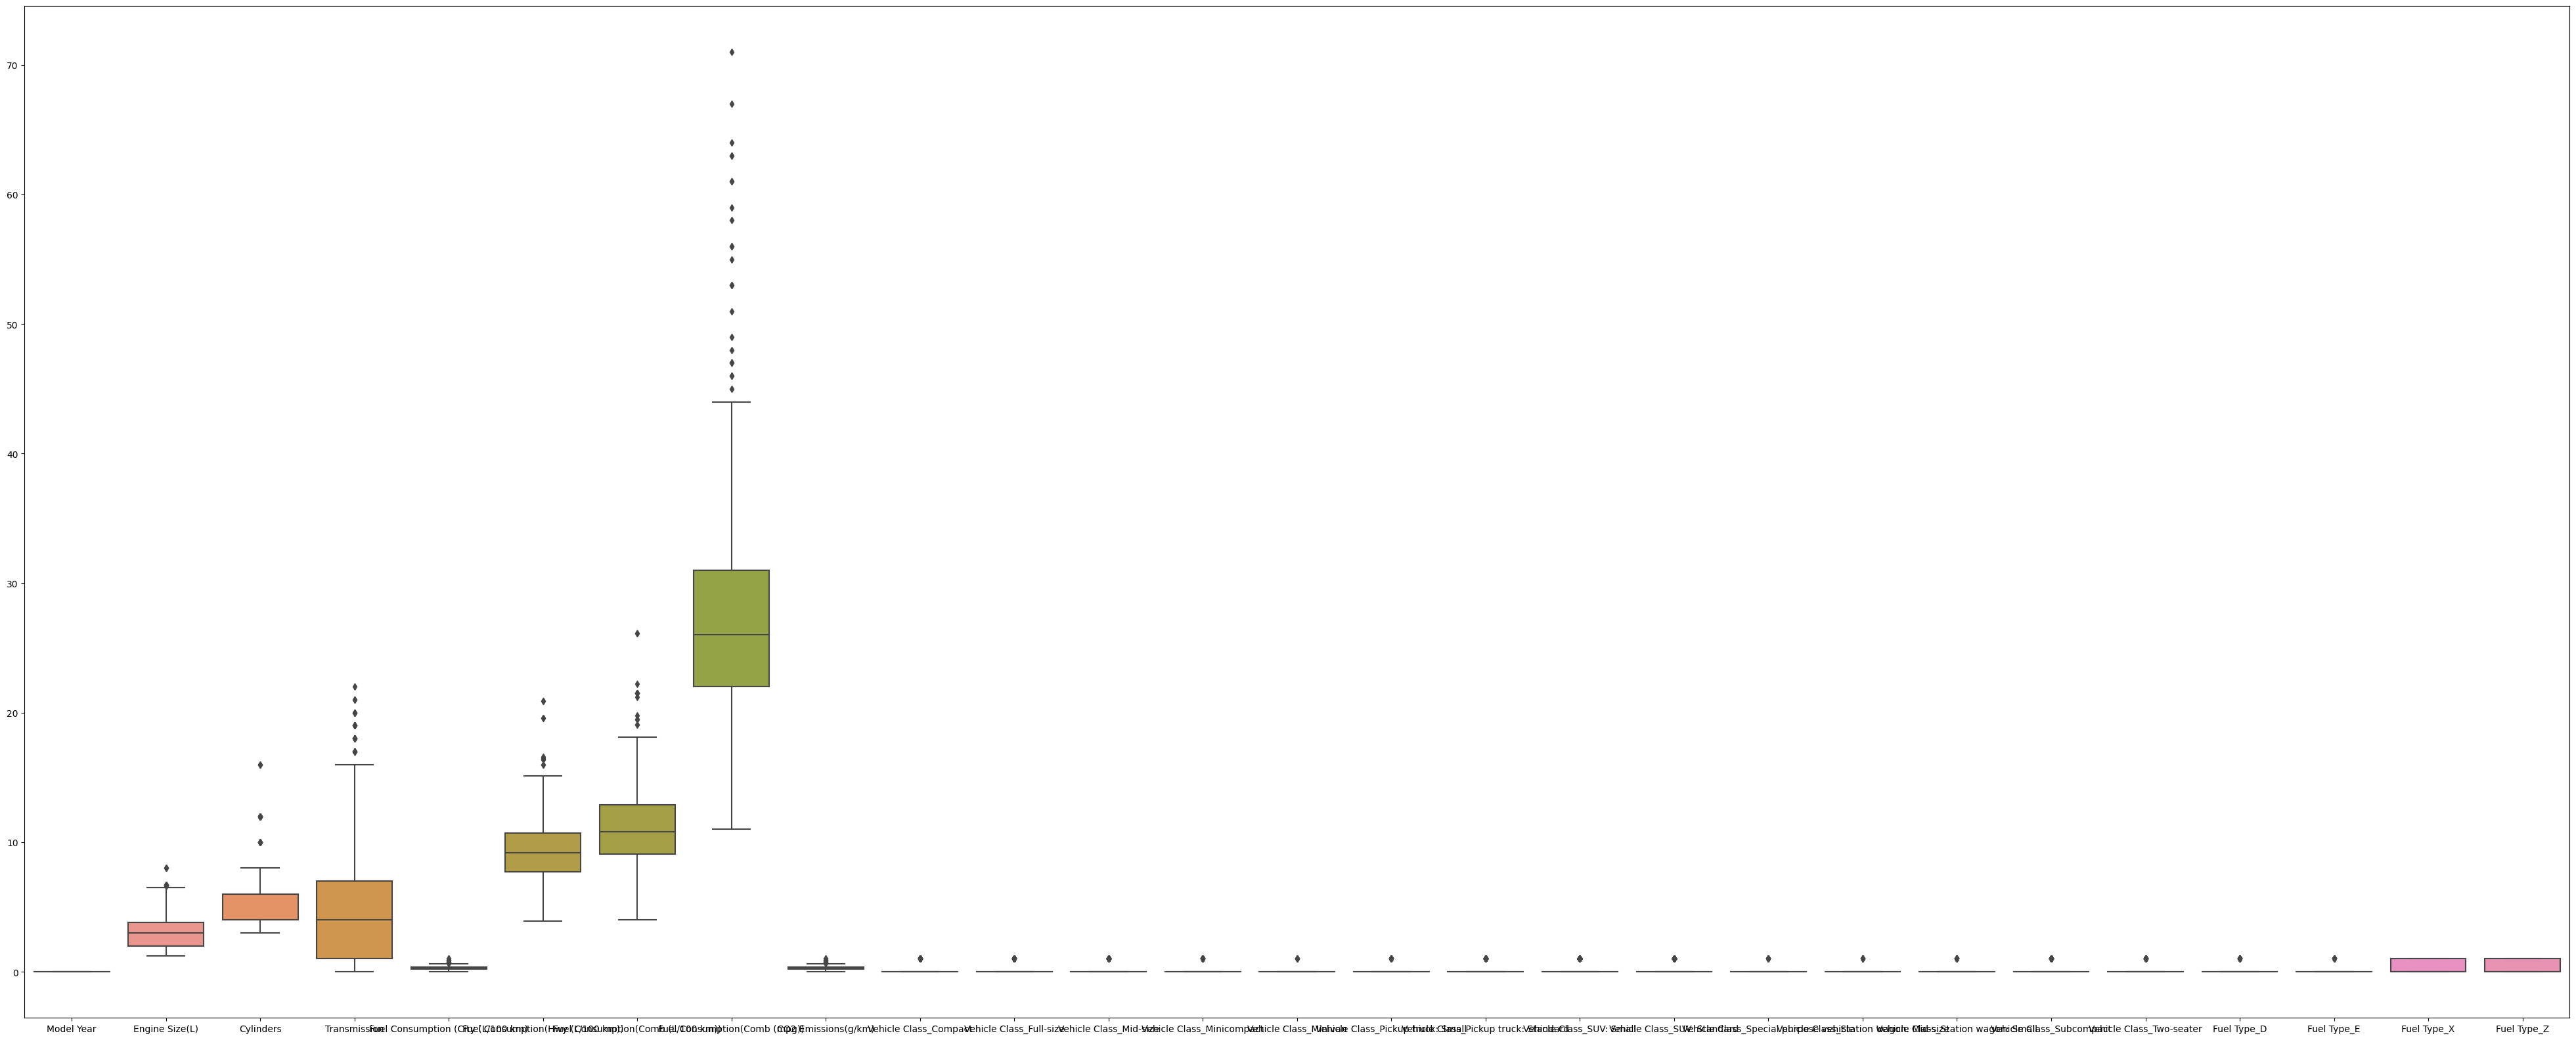

In [81]:
from sklearn import preprocessing

dataScaled = pd.get_dummies(data)
min_max_scalar = preprocessing.MinMaxScaler()

xMo = dataScaled[['Model Year']].values.astype(int)
xMoS = min_max_scalar.fit_transform(xMo)
dataScaled['Model Year'] = pd.DataFrame(xMoS)

xMR = dataScaled[['Fuel Consumption (City (L/100 km)']].values.astype(int)
xMRS = min_max_scalar.fit_transform(xMR)
dataScaled['Fuel Consumption (City (L/100 km)'] = pd.DataFrame(xMRS)

xM = dataScaled[['CO2 Emissions(g/km)']].values.astype(int)
xMS = min_max_scalar.fit_transform(xMR)
dataScaled['CO2 Emissions(g/km)'] = pd.DataFrame(xMS)

plt.figure(figsize=(50, 20))
sns.boxplot(data=dataScaled)
data = dataScaled

The data has now been normalized

<Axes: >

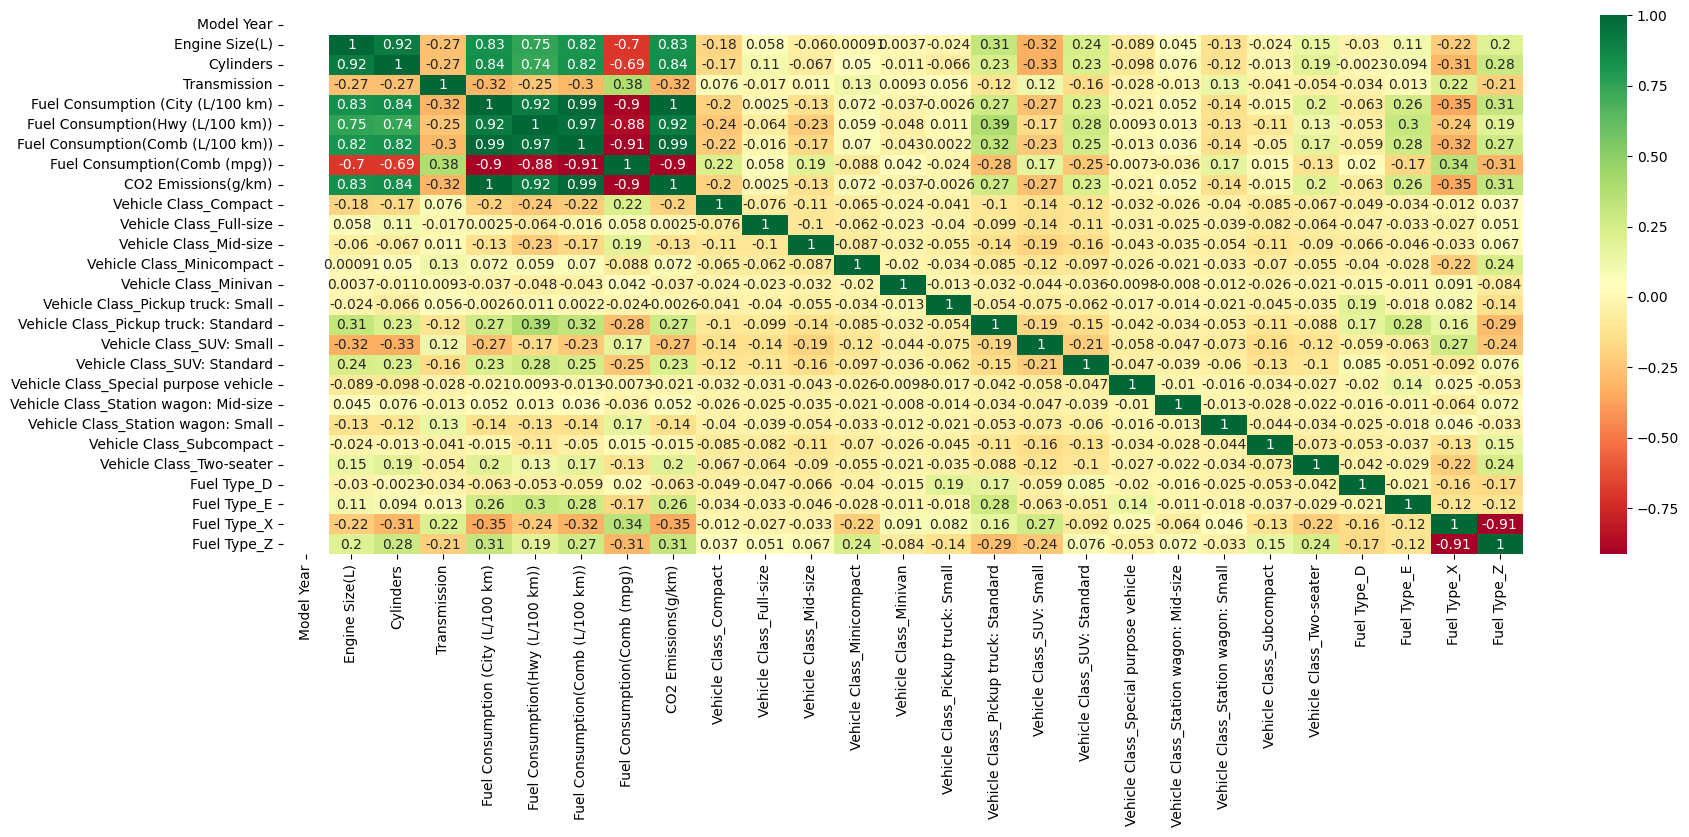

In [82]:
#the heat map of the correlation
plt.figure(figsize=(20,7))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')

We can see there are lot of co-relation among the variables. The co-relation between Fuel Consumption(City(l/100 km)) and Fuel Consumption(Comb(l/100 km)) being the highest (0.99), it means that essentially both are measuring or predicting same thing.

# **Linear regression**
Here we are fitting the data to a linear regression model to predict CO2 Emissions

To do this we will speciy the x and y values and for x value we will drop the column y.

In [83]:
y = data['CO2 Emissions(g/km)']
x = data.drop(['CO2 Emissions(g/km)'], axis = 1)
#x = x.astype('int64')
print(x.info())
print(y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Model Year                             946 non-null    float64
 1   Engine Size(L)                         946 non-null    float64
 2   Cylinders                              946 non-null    int64  
 3   Transmission                           946 non-null    int64  
 4   Fuel Consumption (City (L/100 km)      946 non-null    float64
 5   Fuel Consumption(Hwy (L/100 km))       946 non-null    float64
 6   Fuel Consumption(Comb (L/100 km))      946 non-null    float64
 7   Fuel Consumption(Comb (mpg))           946 non-null    int64  
 8   Vehicle Class_Compact                  946 non-null    uint8  
 9   Vehicle Class_Full-size                946 non-null    uint8  
 10  Vehicle Class_Mid-size                 946 non-null    uint8  
 11  Vehicl

# **OLS Summary**
To better understand if the x values and y values don't have a null hypothesis, we can use OLS Summary.

Null hypothesis is a test to determine if the X and Y value share some sort of relation between each other.

To determine this we will look at F-Statistic of the OLS Summary. If the value is 0 then there is no relationship between the X and Y value. If the value is greater than 0 it means there is a relationship. The higher the value of F-statistic, the stronger the relationship between the X and Y value.

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.25,shuffle = True)
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

x_value = data.drop(['CO2 Emissions(g/km)'], axis = 1)
linear_model = sm.OLS(data['CO2 Emissions(g/km)'], x_value).fit()
print(linear_model.summary())

                             OLS Regression Results                            
Dep. Variable:     CO2 Emissions(g/km)   R-squared:                       1.000
Model:                             OLS   Adj. R-squared:                  1.000
Method:                  Least Squares   F-statistic:                 2.904e+30
Date:                 Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                         23:29:23   Log-Likelihood:                 31998.
No. Observations:                  946   AIC:                        -6.395e+04
Df Residuals:                      922   BIC:                        -6.383e+04
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

# **Analysis**
As we can see above, the F-Statistics value is not 0 and thus we can safely assume that there is a relationship the X and Y value.

Further we can also look at T-Statistics values and see that some of the values imapact the values in postivie and negative way significantly. This can be further analysed using SHAP analysis.

For the next step, we will be using a simple Linear regressor as our model and perform SHAP analysis on.



# **What is the question?**
In this dataset we are trying to predict the CO2 Emissions, based on the input values. For this we can use Null Hypothesis to state if there is a relationship between the input and output variables.

As seen in the above OLS summary the F-Statistic value is not equal to 0, which indicates that there is a relationship between X and Y.

# **Simple Linear Regression**

     Y_Predictions  Y_actual
0     5.384615e-01  0.192308
1     6.153846e-01  0.307692
2     3.076923e-01  0.269231
3     1.256431e-15  0.269231
4     2.307692e-01  0.269231
..             ...       ...
705   2.307692e-01  0.153846
706   2.307692e-01  0.230769
707   2.307692e-01  0.230769
708   2.307692e-01  0.153846
709   2.307692e-01  0.230769

[530 rows x 2 columns]
The mean squared error is: 0.03363291280562689
The R^2 score on train data is: 1.0
                              ColumnNames  Coefficients
0                              Model Year  8.135302e-15
1                          Engine Size(L) -1.734723e-17
2                               Cylinders  2.707685e-16
3                            Transmission -1.052477e-16
4       Fuel Consumption (City (L/100 km)  1.000000e+00
5        Fuel Consumption(Hwy (L/100 km)) -2.460663e-16
6       Fuel Consumption(Comb (L/100 km))  1.066905e-16
7            Fuel Consumption(Comb (mpg))  2.644008e-17
8                   Vehicle Class_Compact

<Axes: >

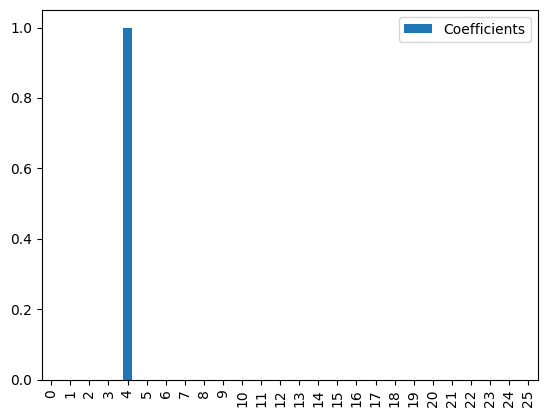

In [85]:
from sklearn.metrics import mean_squared_error
Linear_regression = LinearRegression().fit(x_train, y_train)
y_prediction = Linear_regression.predict(x_test)
coeff = Linear_regression.coef_
analysis = pd.DataFrame()
analysis['Y_Predictions'] = y_prediction
analysis['Y_actual'] = y_test
analysis = analysis.dropna()
print(analysis)
#sns.residplot(x = analysis['Y_actual'], y = analysis['Y_Predictions'])
pad = pd.DataFrame()
pad['ColumnNames'] = x_train.columns
pad['Coefficients'] = coeff
print("The mean squared error is: {}".format(mean_squared_error(analysis['Y_actual'], analysis['Y_Predictions'])))
print("The R^2 score on train data is: {}".format(Linear_regression.score(x_train, y_train)))
print(pad)
pad.plot.bar()

# **SHAP Analysis**
SHAP (SHapley Additive exPlanations) analysis is a model-agnostic method for explaining the output of any machine learning model. It aims to provide a global and local understanding of the importance of each feature in a model's output.

For analysis, we will plot summaries of the model, use waterfall analysis to determine the importance of features and their impact on the final prediction, use feature importance for all the values of the model, use dependance plots to show how values are dependant on eachother and use heatmap to see contribution of each feature to the final prediction made by the model for a hetter undestanding

Permutation explainer: 237it [00:14,  6.71it/s]                         


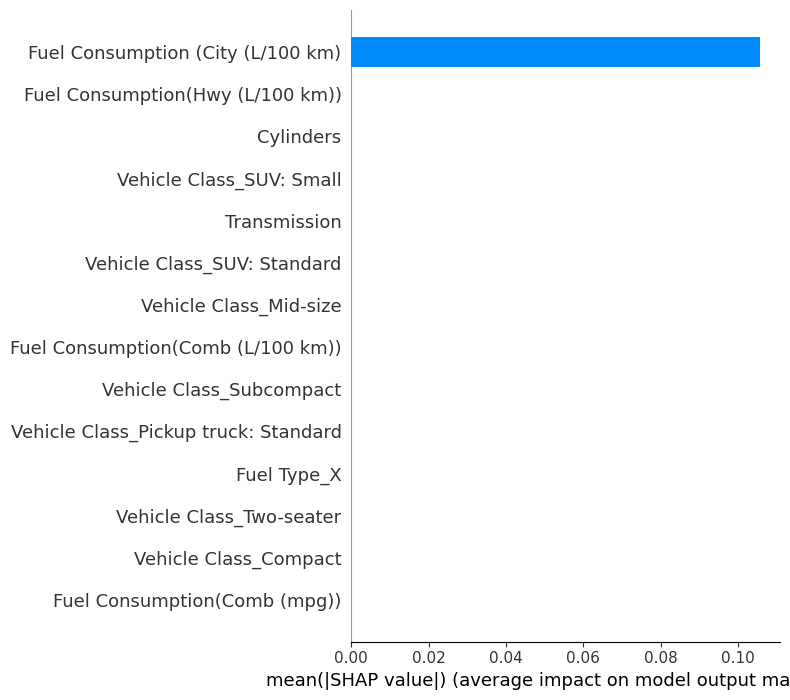

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


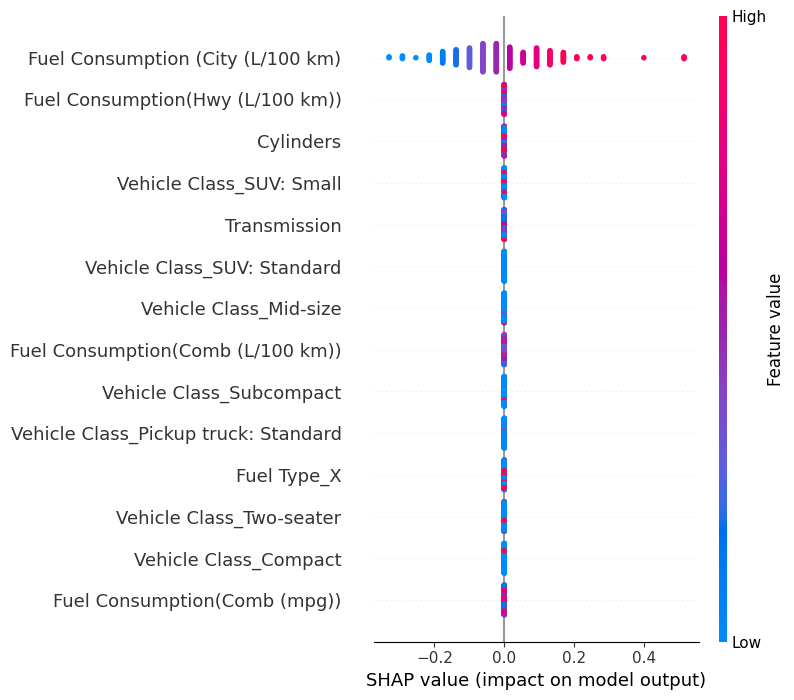

Waterfall plot for linear regression


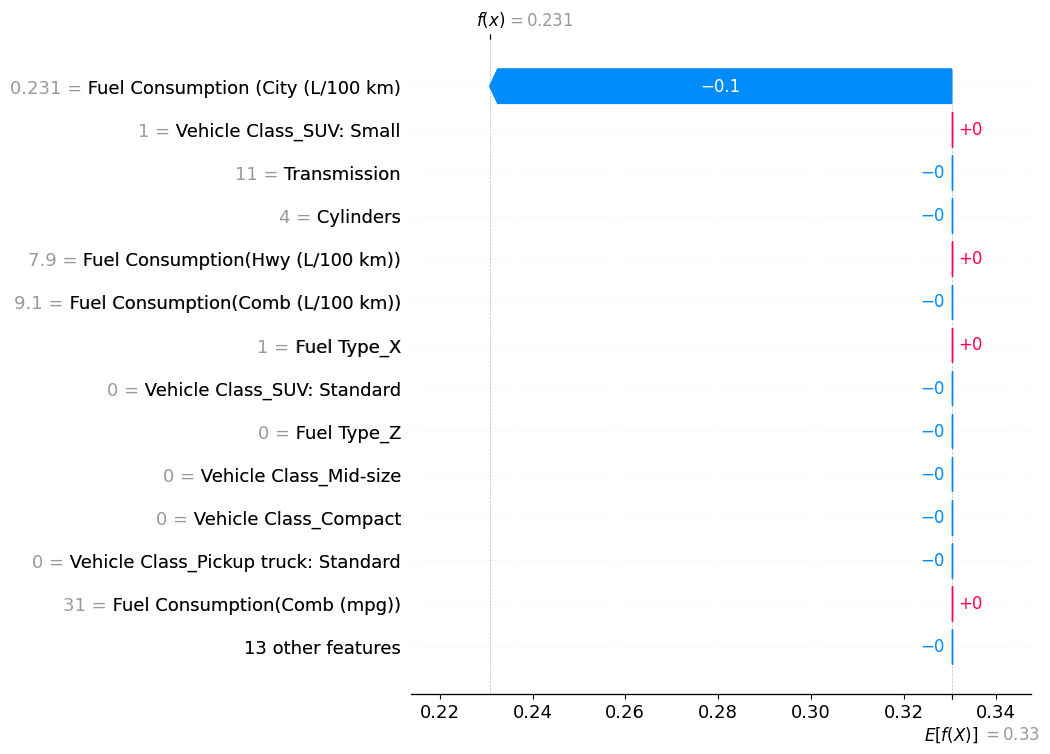

In [86]:
linear_explainer_shap = shap.Explainer(Linear_regression.predict, x_train)
shap_values_linear_regression = linear_explainer_shap(x_train)
shap.summary_plot(shap_values_linear_regression, x_train, plot_type = 'bar', max_display=14)
shap.summary_plot(shap_values_linear_regression, x_train, max_display = 14)

print("Waterfall plot for linear regression")
shap.plots.waterfall(shap_values_linear_regression[30], max_display = 14)

From above, we can see that the distribution of shaply values is more for FuelConsumption(Comb (L/100km)). However, to determine the positive and negative importance of the values we will not specify the plot type as bar and just see the summary of the shap values.

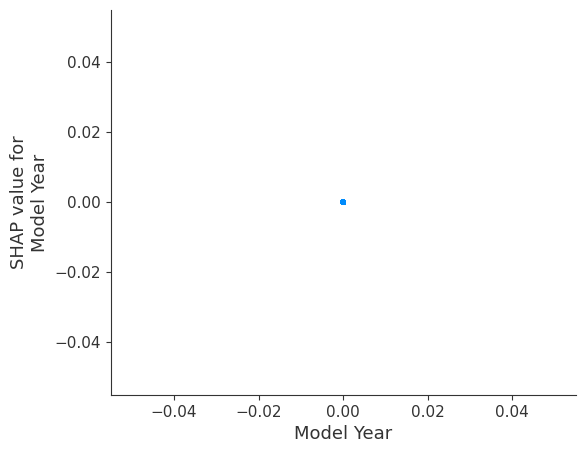

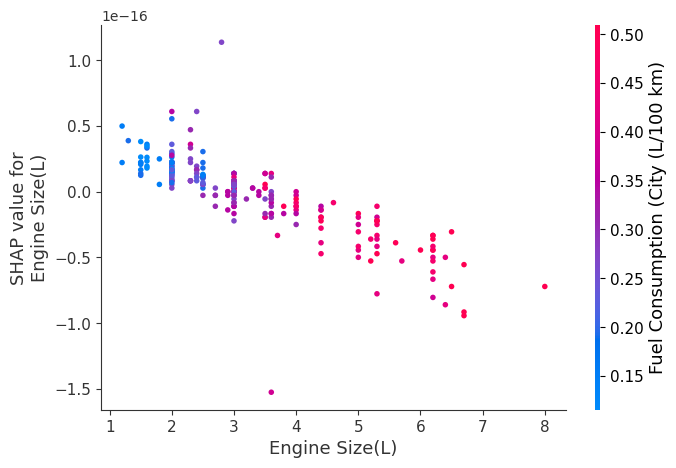

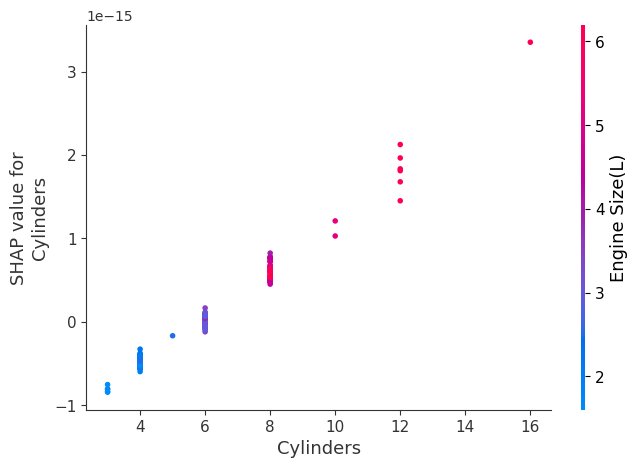

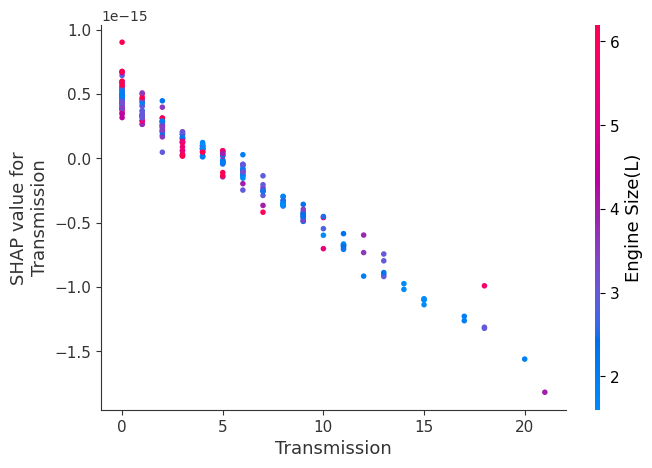

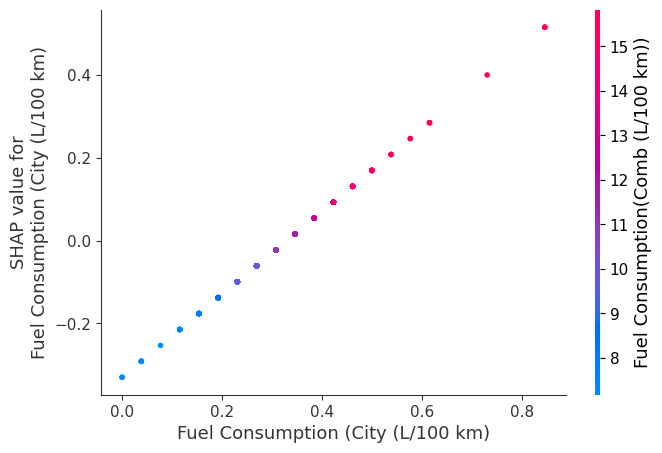

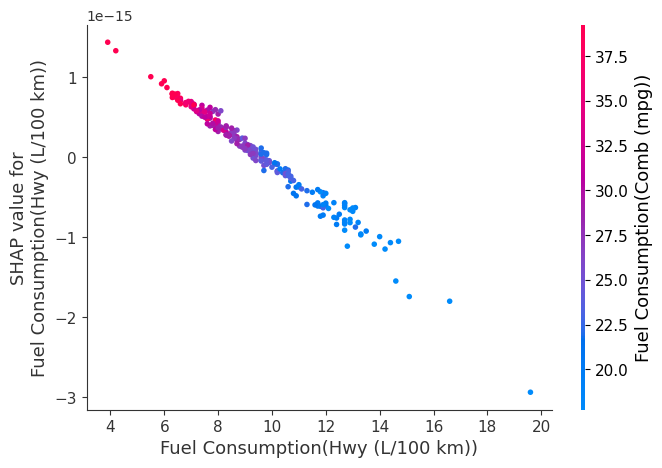

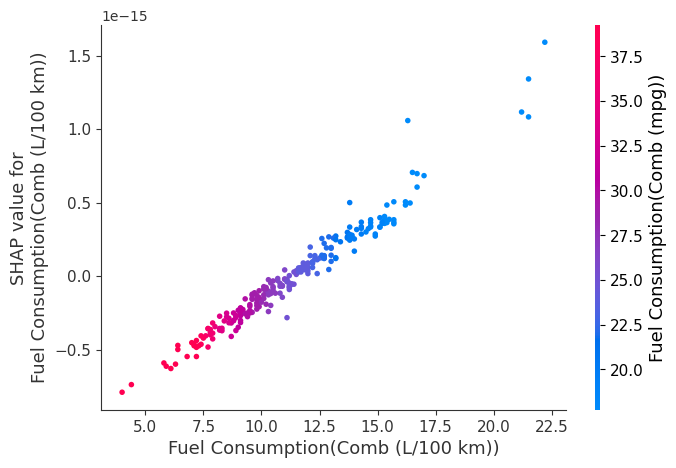

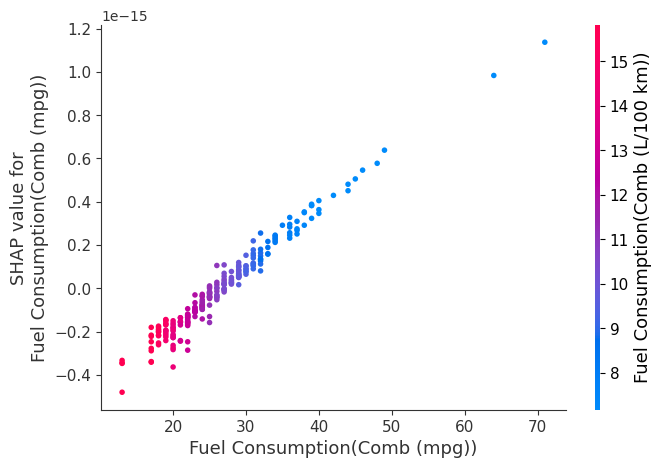

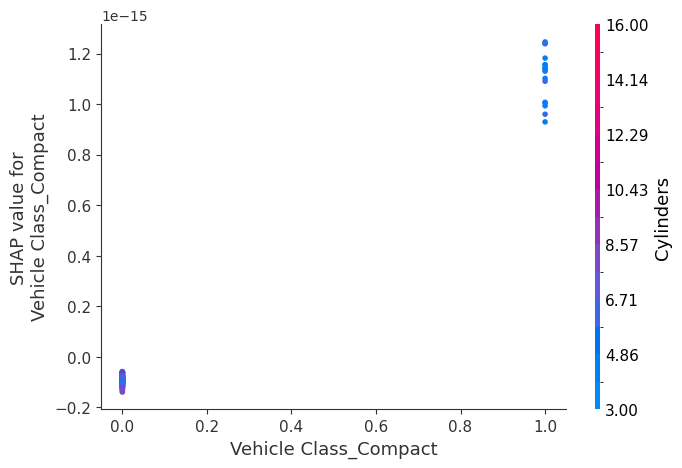

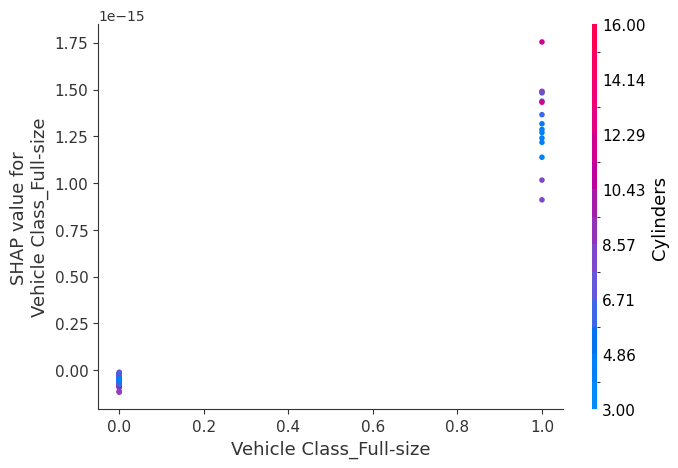

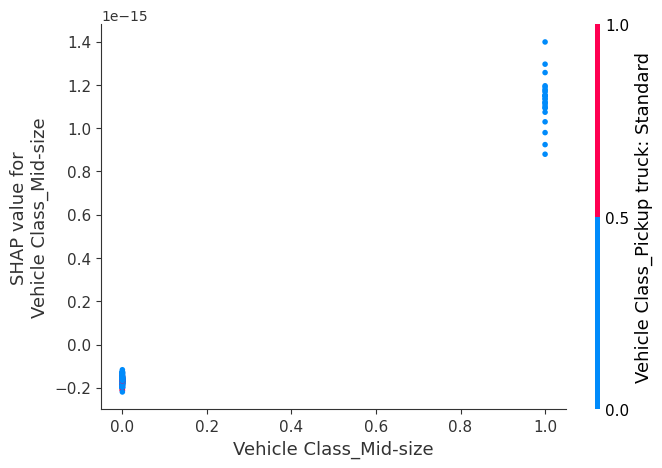

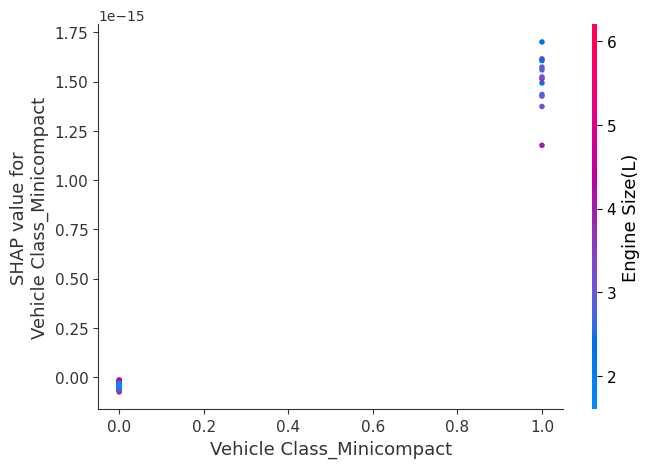

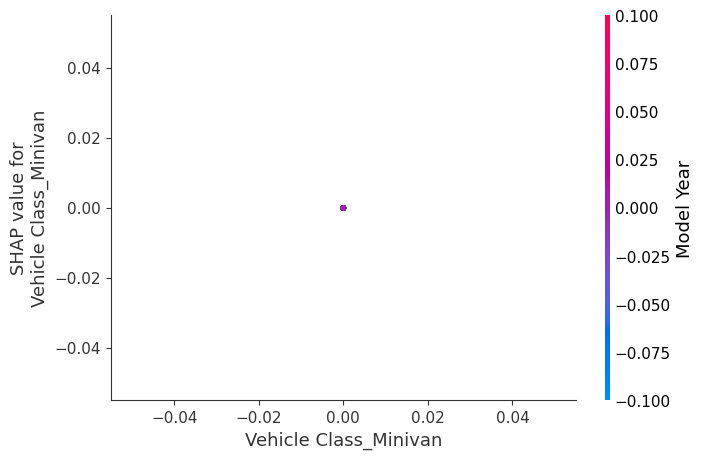

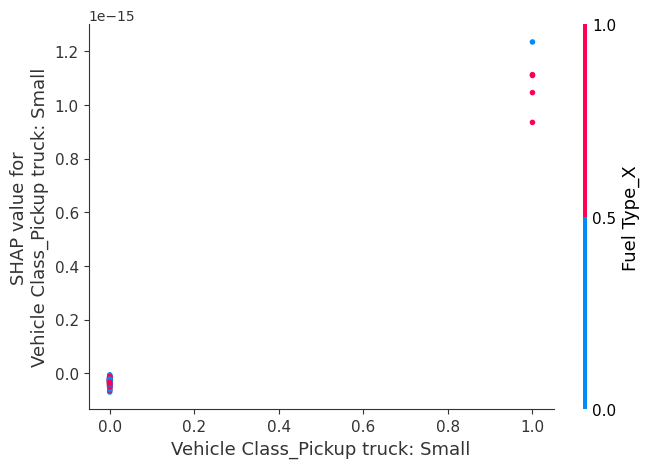

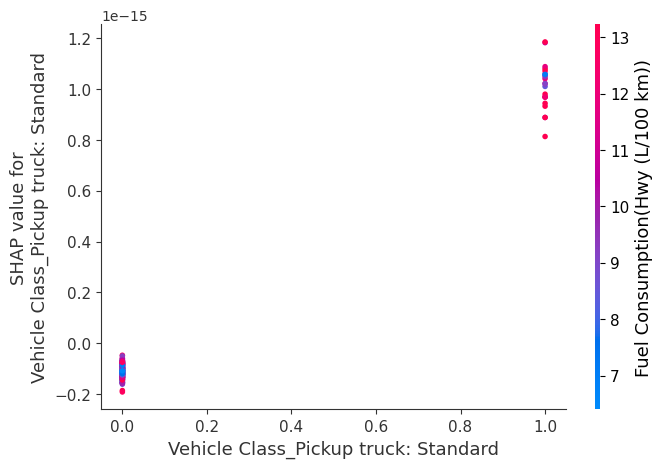

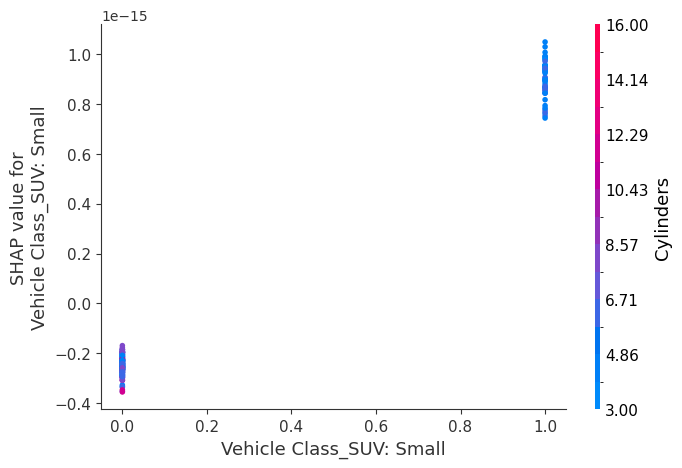

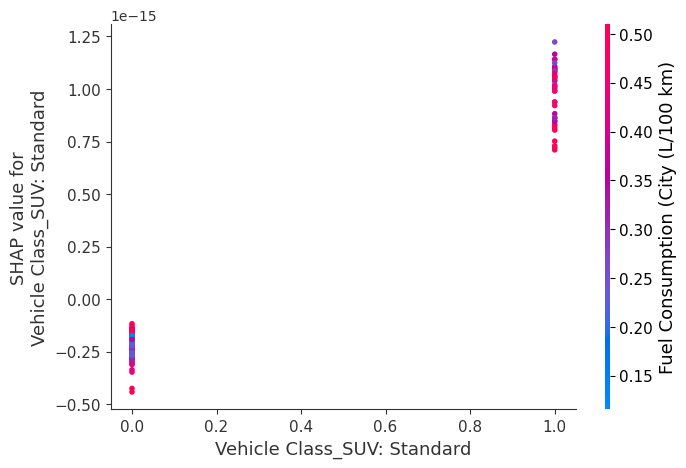

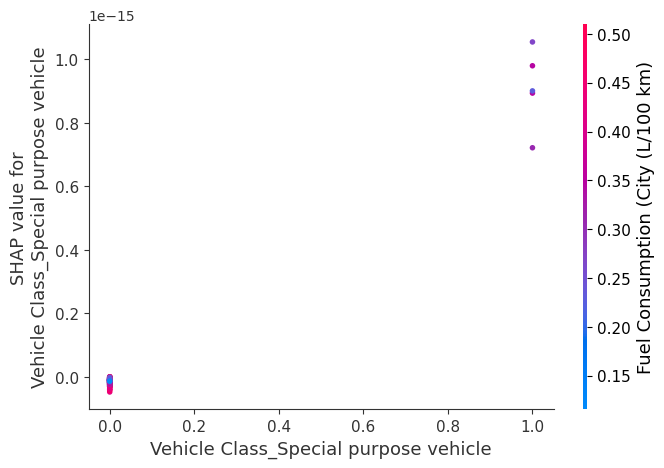

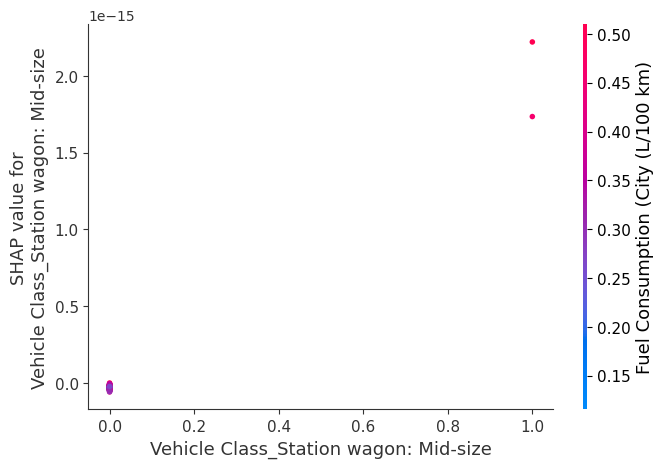

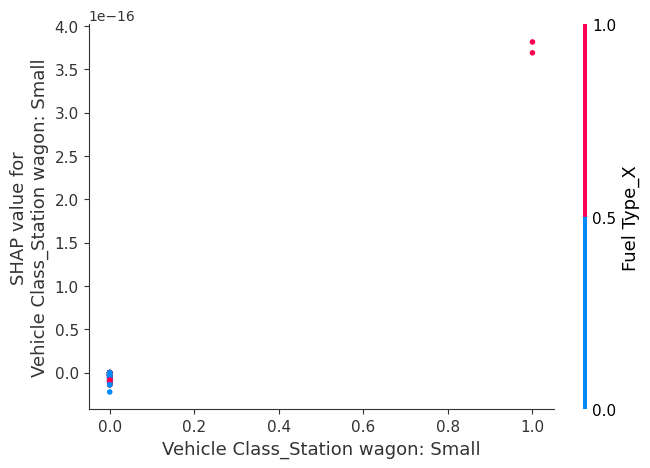

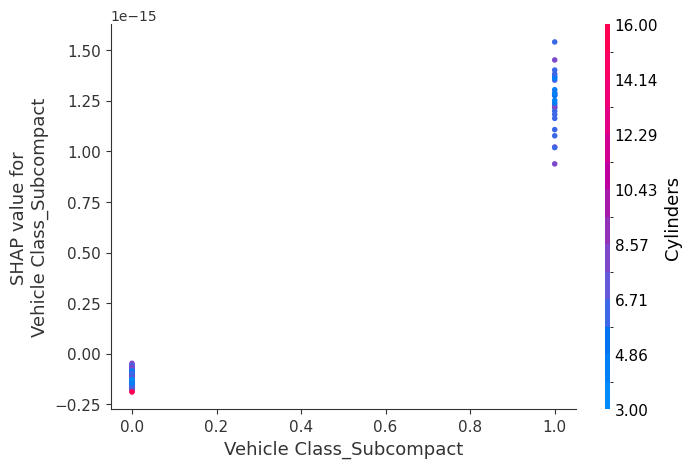

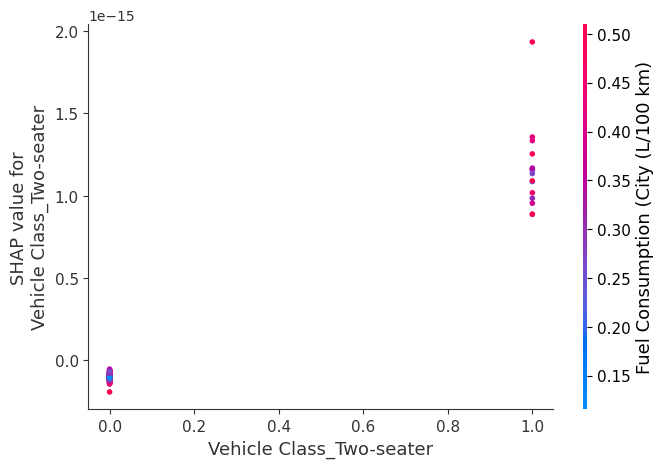

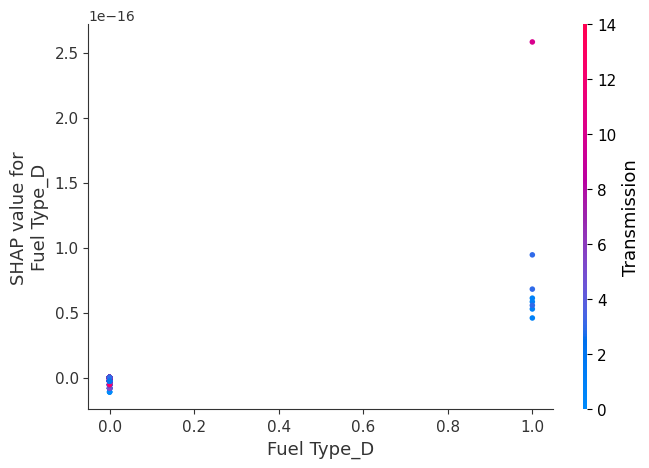

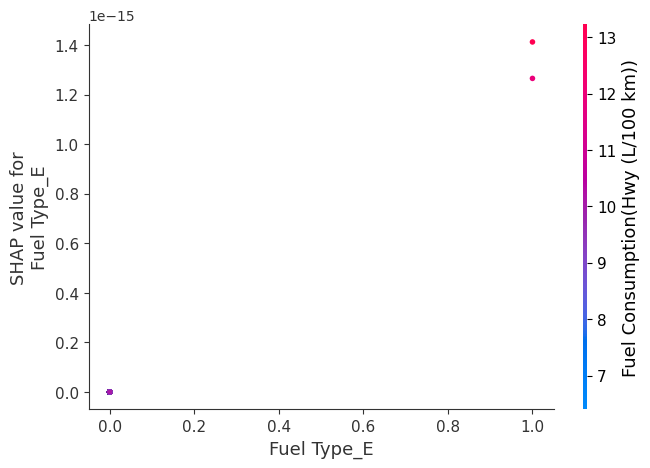

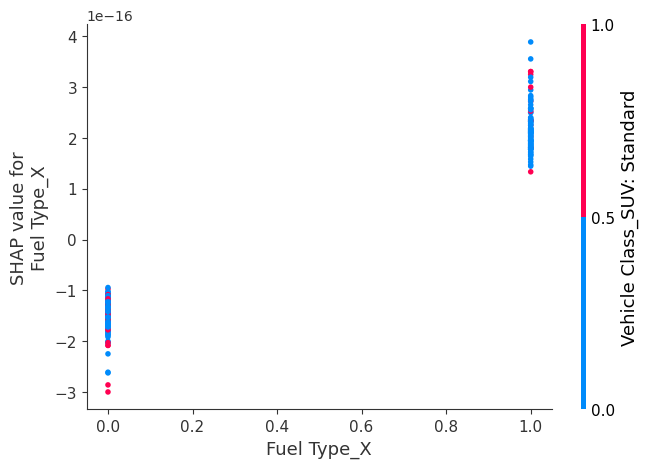

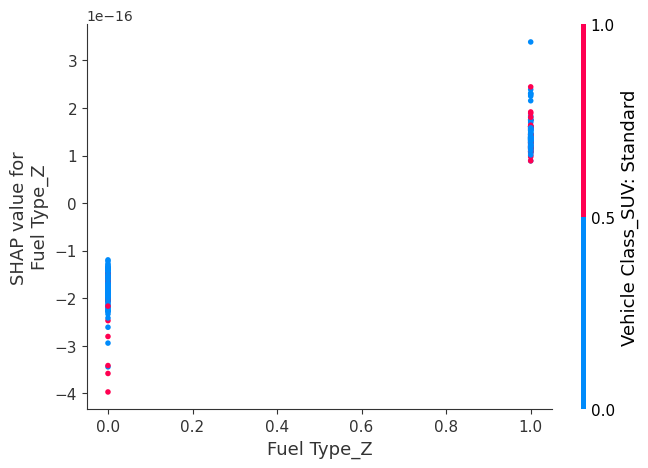

In [87]:
for i in x_train.columns:
  shap.dependence_plot(i, shap_values_linear_regression.values, x_train)

Waterfall plot for linear regression


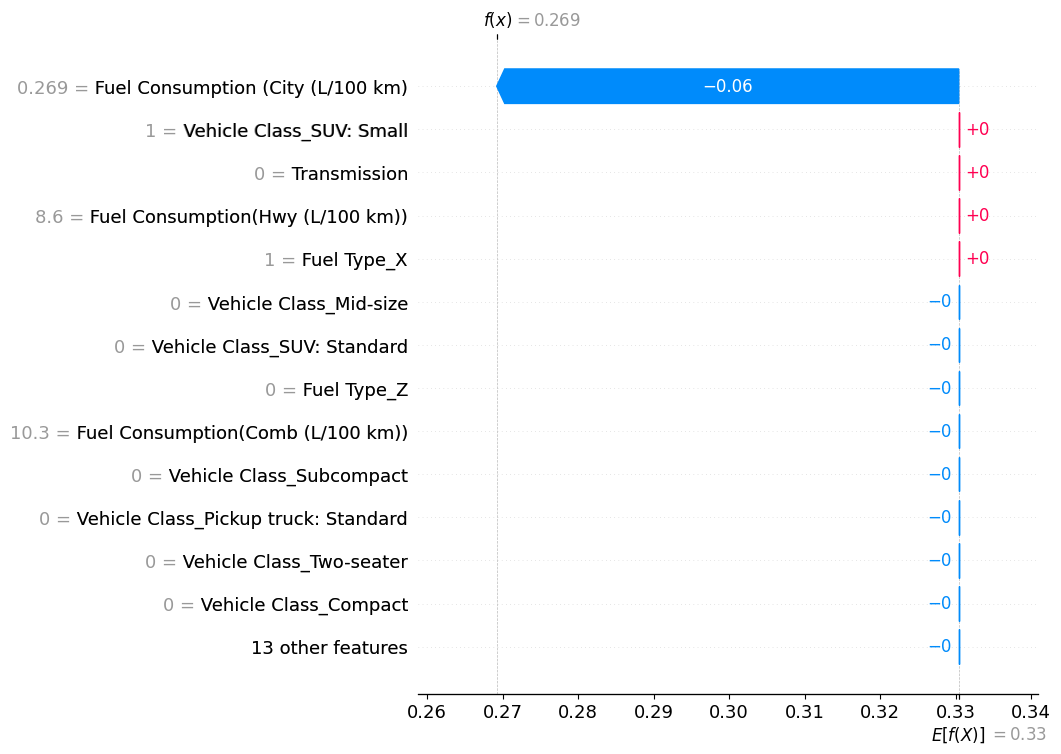

In [105]:
print("Waterfall plot for linear regression")
shap.plots.waterfall(shap_values_linear_regression[22], max_display = 14)

Now where the above summary plot gave the general distribution of shap valuese, the waterfall plot is used to see for one single instance of the data which value has a positive and negative impact on the output value. This is better to further analyze variable importance at per instance level.

# **Decision Tree**

A decision tree is a supervised learning algorithm used in machine learning and data mining for classification and regression tasks. It is a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility.

In a decision tree, each node represents a decision or a feature, and each branch represents an outcome or a possible value of that feature. The leaves of the tree represent the final decision or the predicted outcome. The tree is constructed by recursively splitting the dataset into smaller subsets based on the values of the features until the subsets are homogeneous or the stopping criteria are met.

     Y_Predictions  Y_actual
0         0.538462  0.192308
1         0.615385  0.307692
2         0.307692  0.269231
3         0.000000  0.269231
4         0.230769  0.269231
..             ...       ...
705       0.230769  0.153846
706       0.230769  0.230769
707       0.230769  0.230769
708       0.230769  0.153846
709       0.230769  0.230769

[530 rows x 2 columns]
The mean squared error is: 0.033708272859216265
The R^2 score on train data is: 1.0


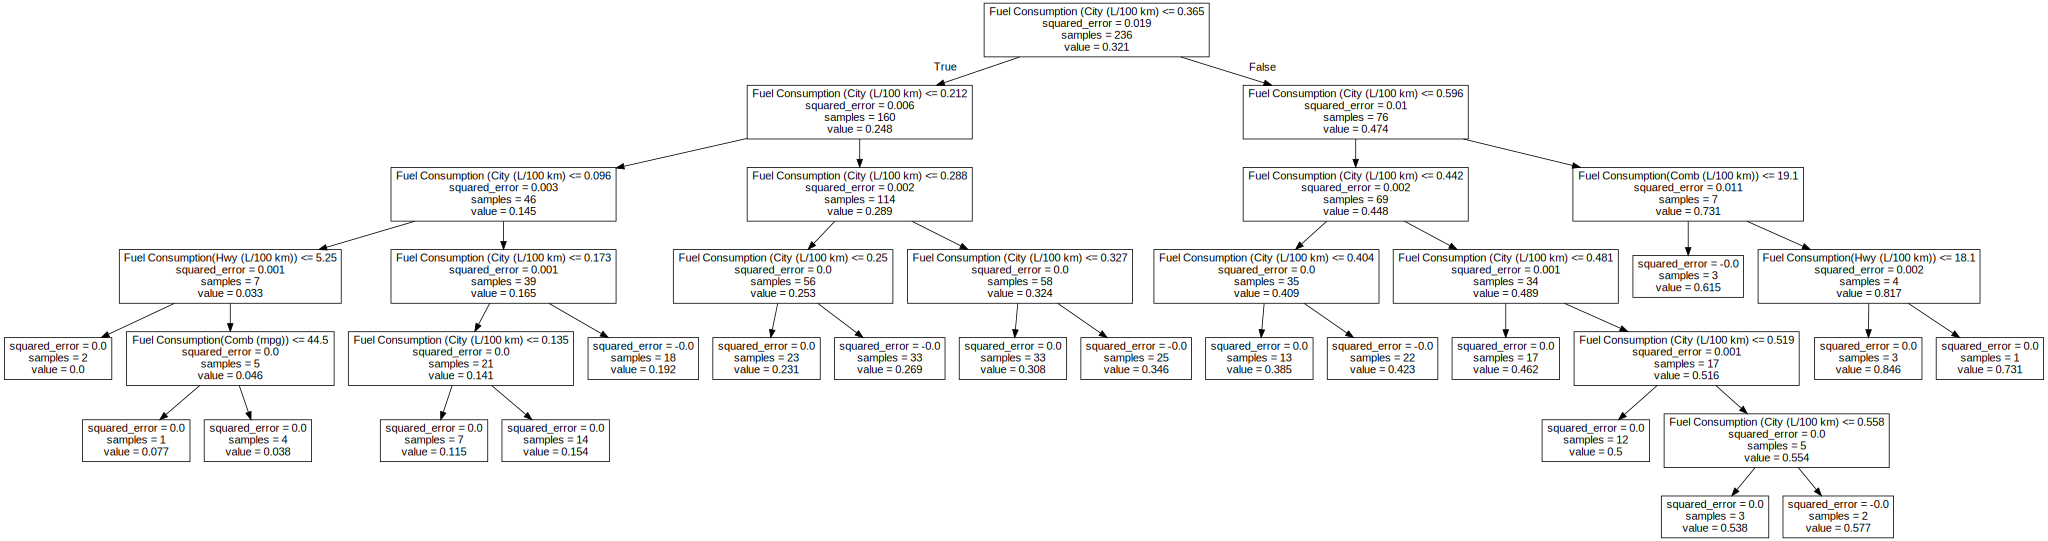

In [89]:
from sklearn import tree
import graphviz

regressor = tree.DecisionTreeRegressor(random_state=1, max_depth=6)
regressor = regressor.fit(x_train, y_train)
predictions = regressor.predict(x_test)
analysis = pd.DataFrame()
analysis['Y_Predictions'] = predictions
analysis['Y_actual'] = y_test
analysis = analysis.dropna()
print(analysis)
#sns.residplot(x = analysis['Y_actual'], y = analysis['Y_Predictions'])
print("The mean squared error is: {}".format(mean_squared_error(analysis['Y_actual'], analysis['Y_Predictions'])))
print("The R^2 score on train data is: {}".format(Linear_regression.score(x_train, y_train)))

### Visualizing the decision tree graph.
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=list(x_train.columns))
graph = graphviz.Source(dot_data)
graph

# **Shap analysis (For decision tree)**
Similarly like above we will be doing shap analysis for our decision tree model.

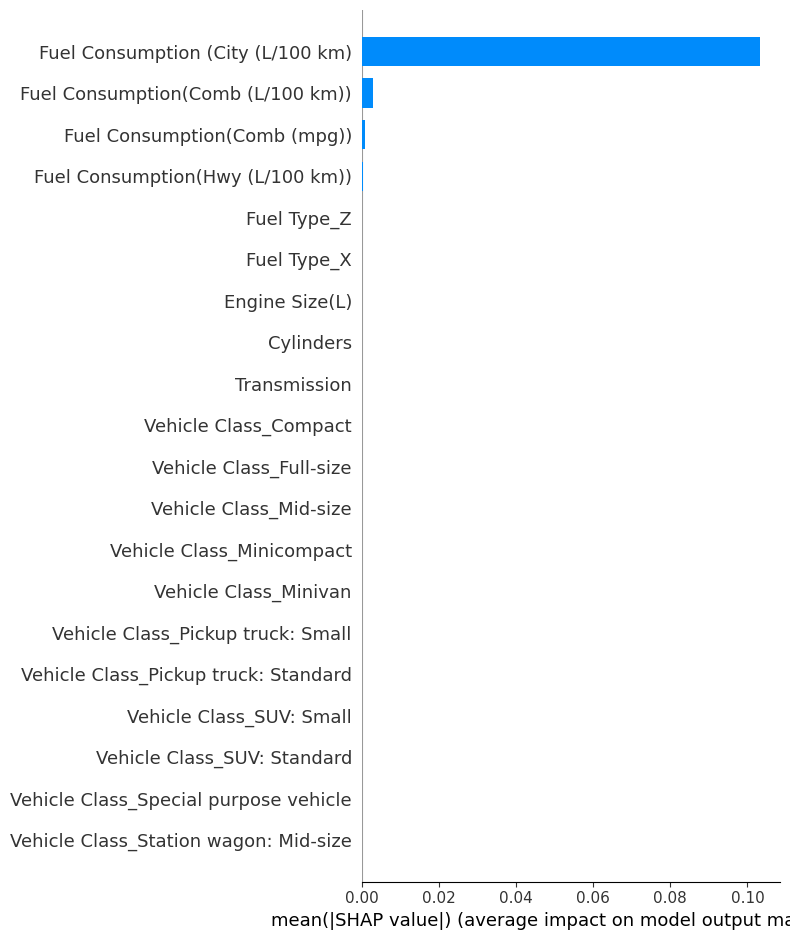

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


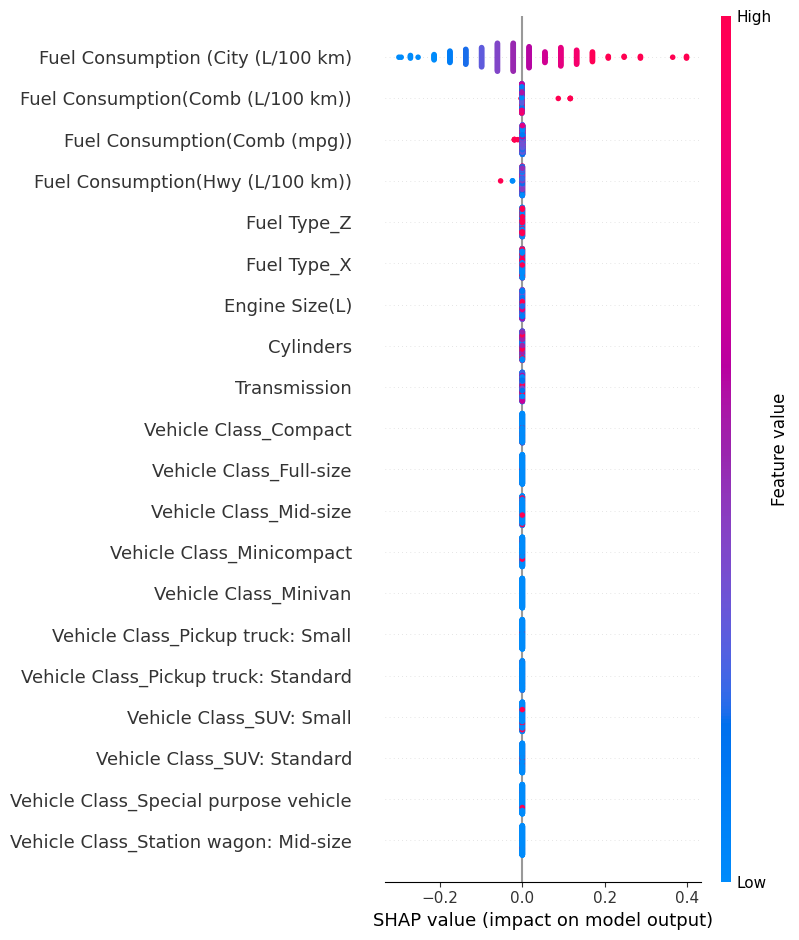

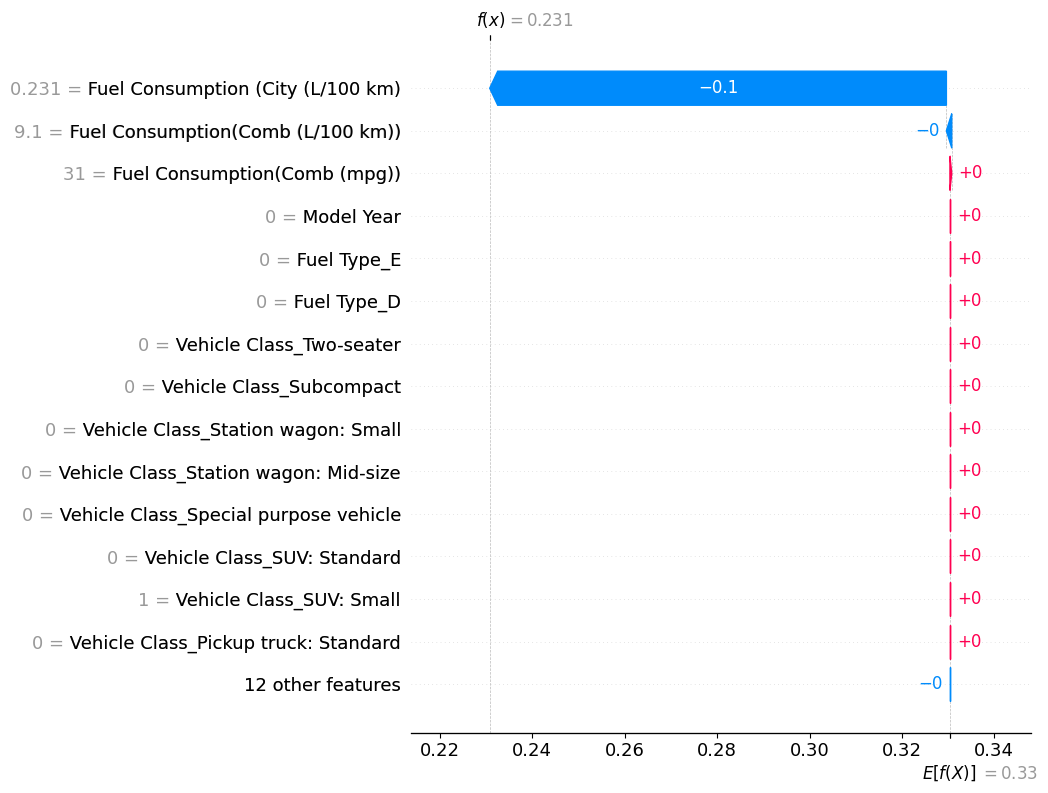

In [90]:
explainer = shap.Explainer(regressor.predict, x_train)
shap_values_decision_tree = explainer(x_train)
shap.summary_plot(shap_values_decision_tree, x_train, plot_type="bar")
shap.summary_plot(shap_values_decision_tree, x_train)
shap.plots.waterfall(shap_values_decision_tree[30], max_display=15)

# **Shap variable importance plots**

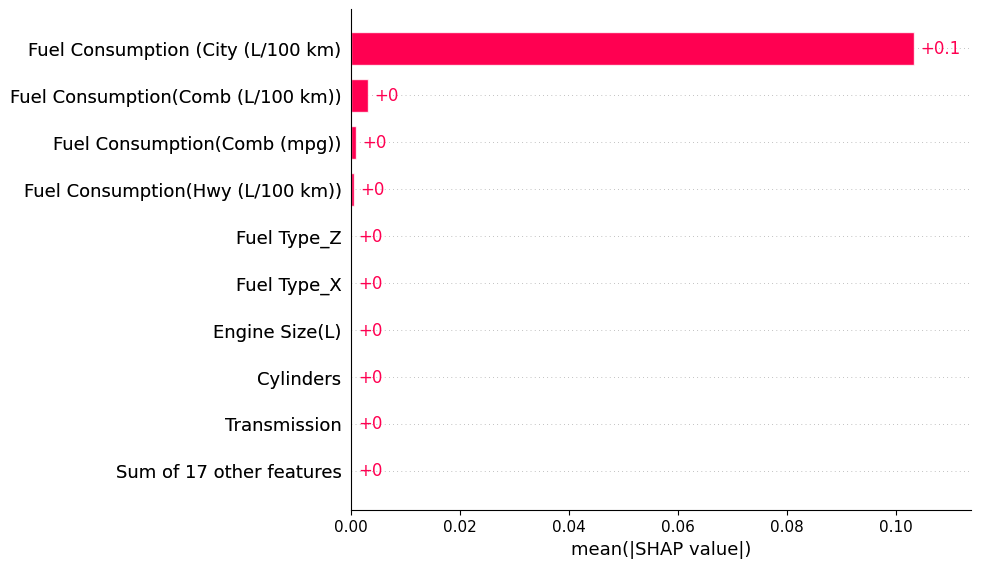

In [91]:
shap.plots.bar(shap_values_decision_tree)

# SHAP Dependance plots

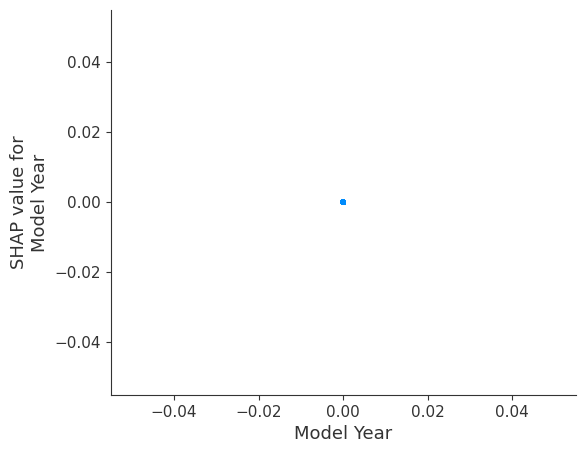

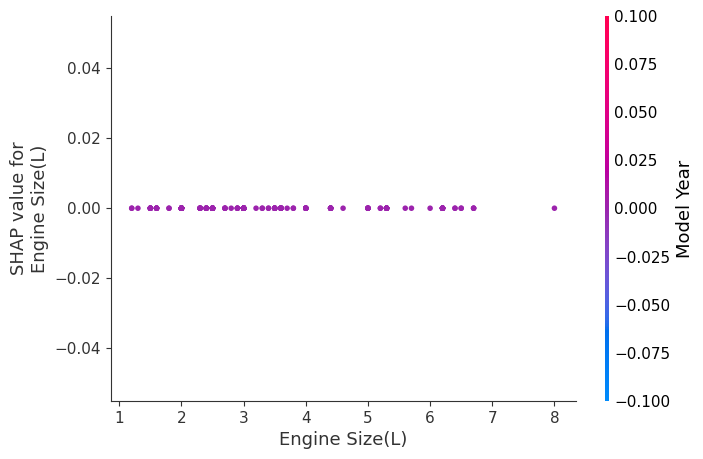

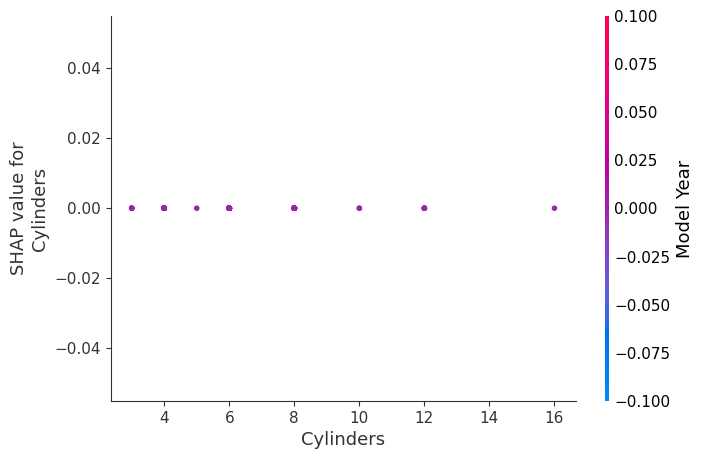

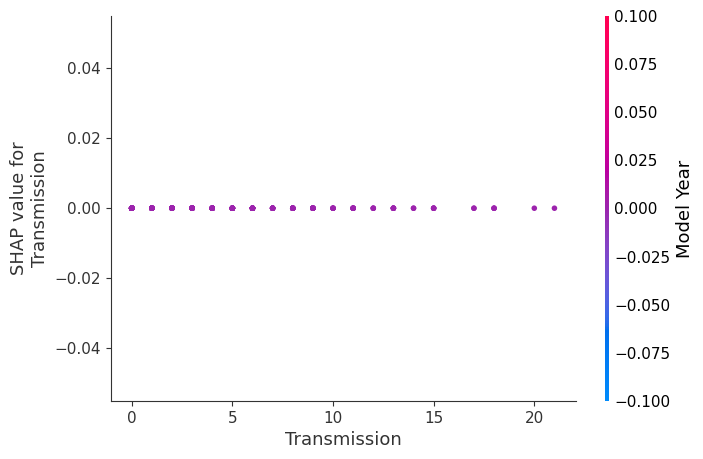

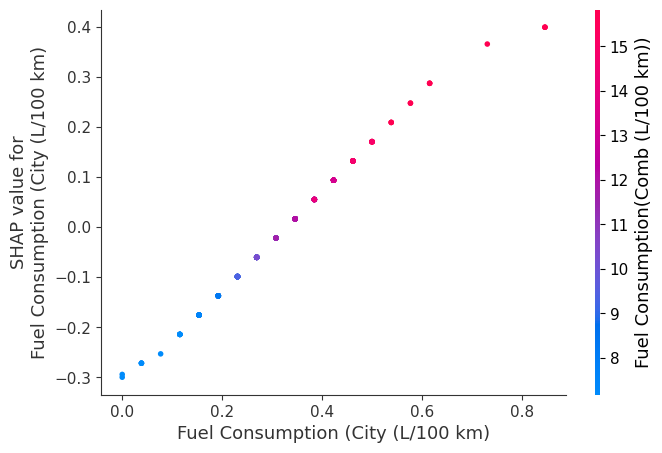

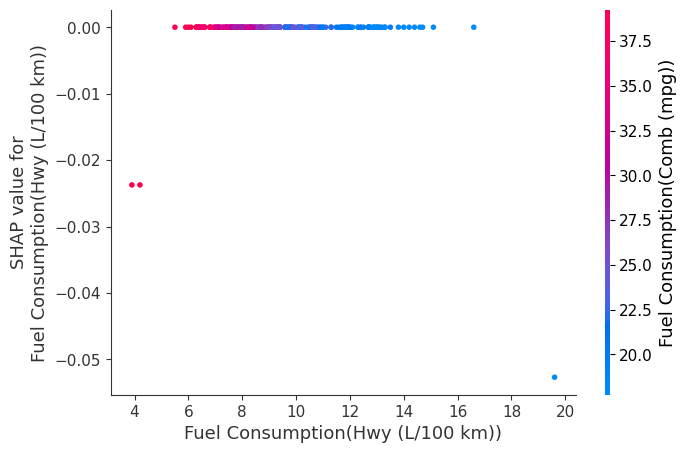

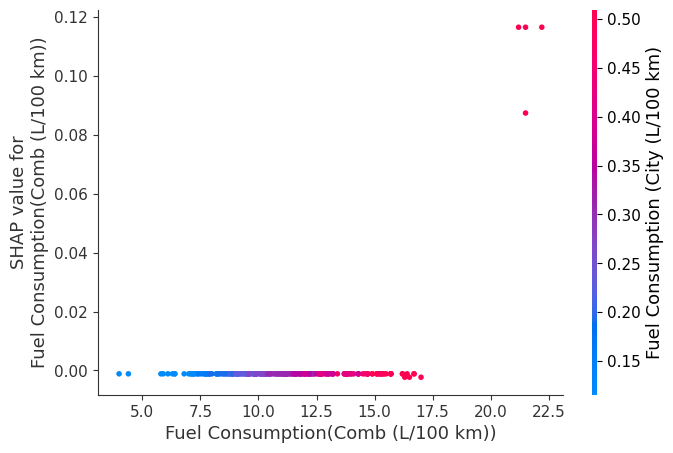

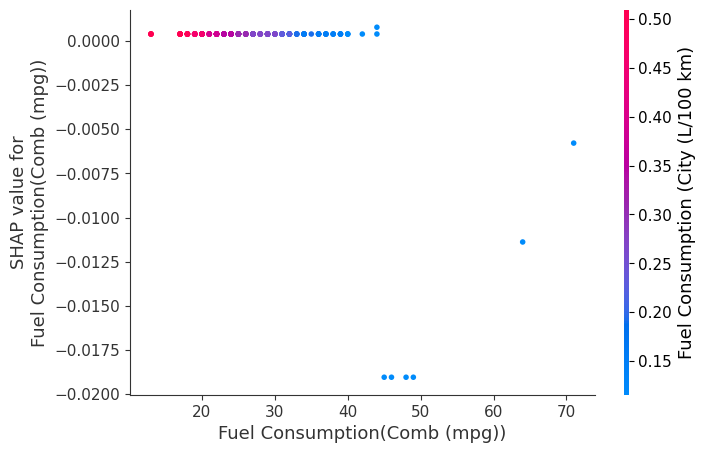

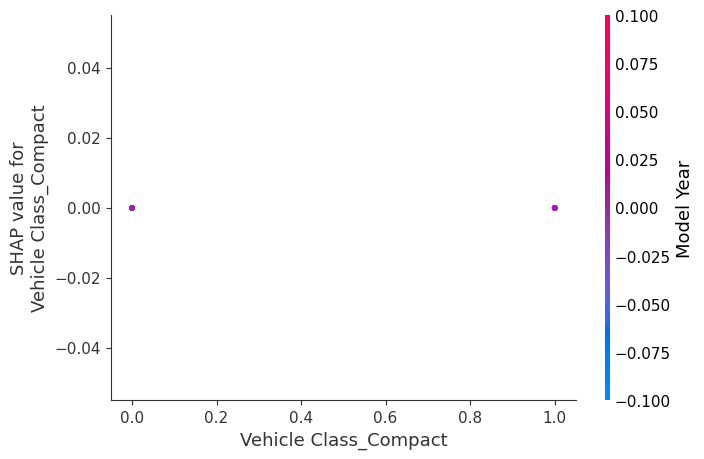

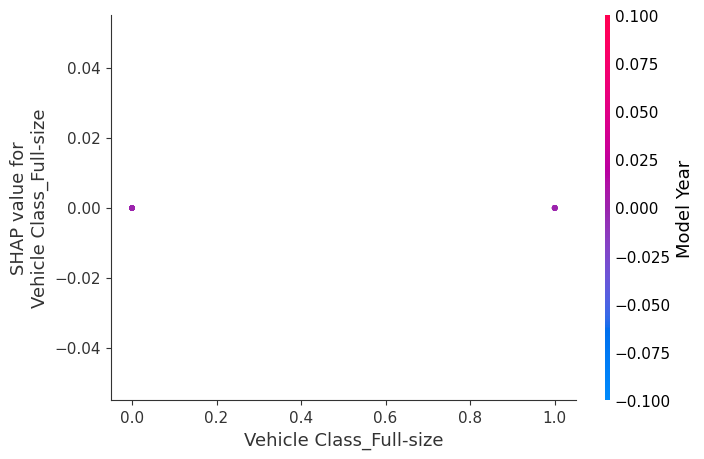

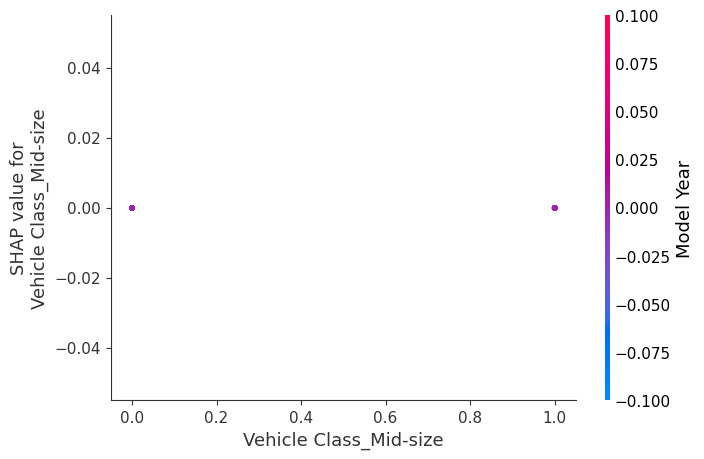

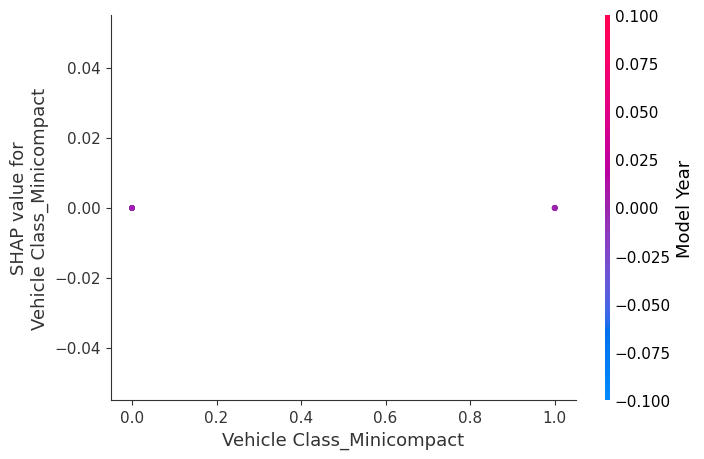

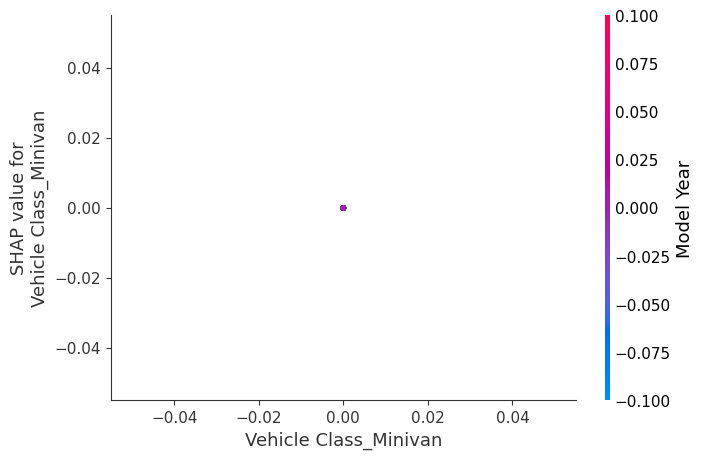

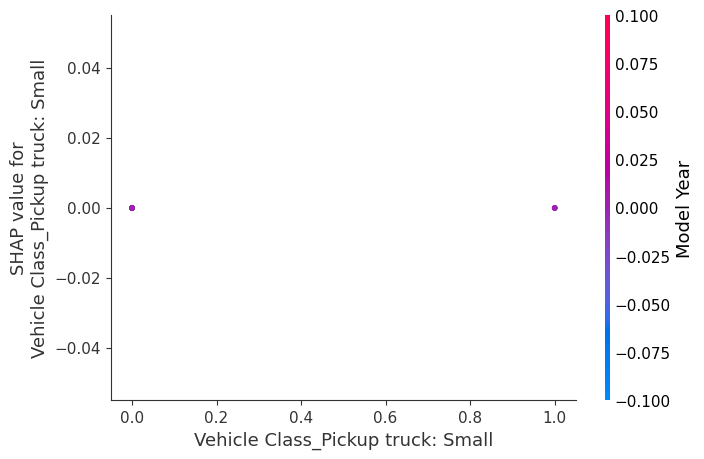

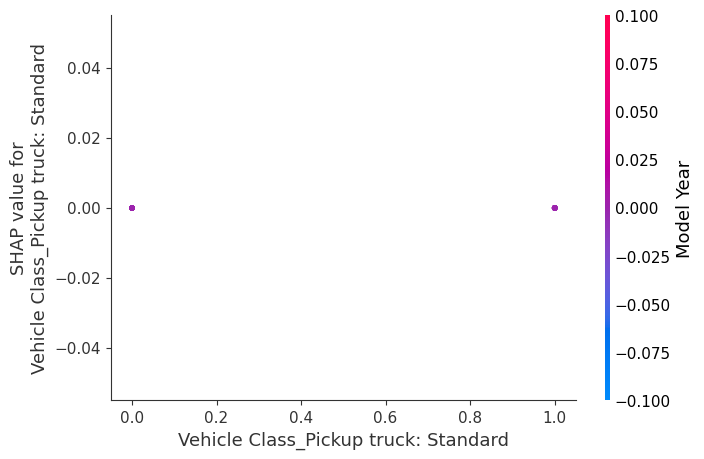

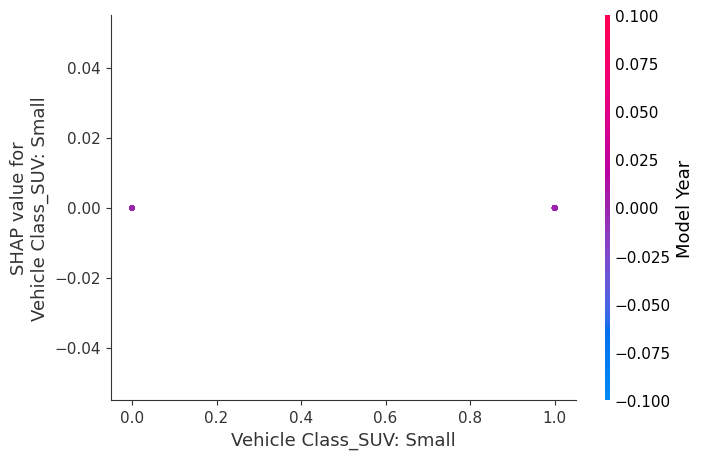

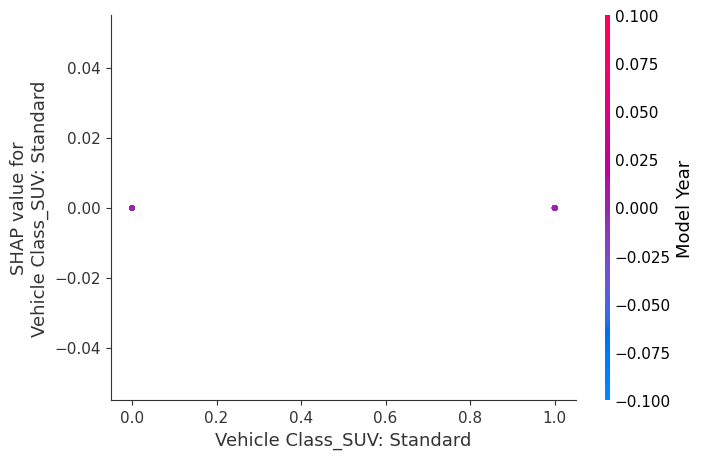

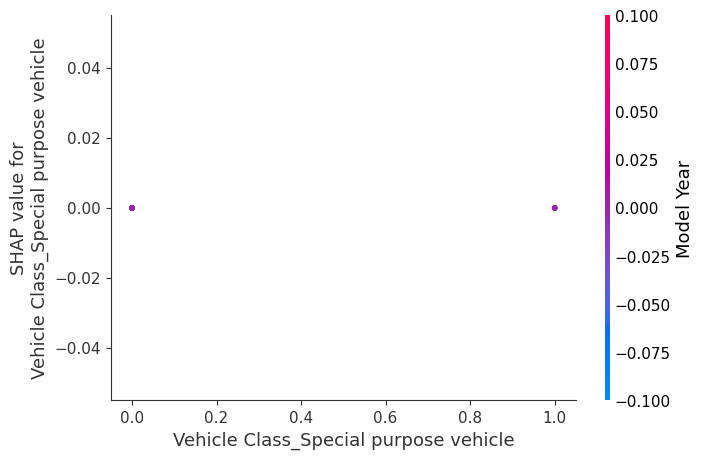

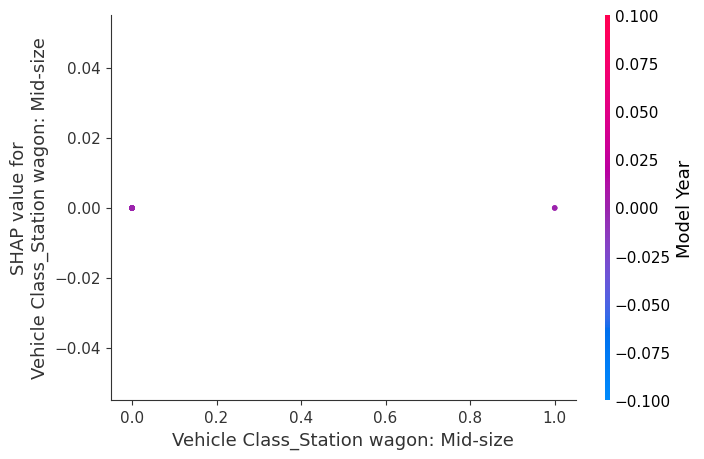

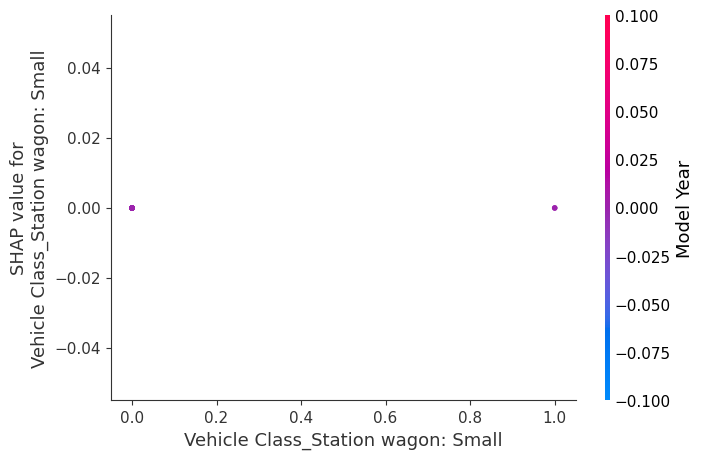

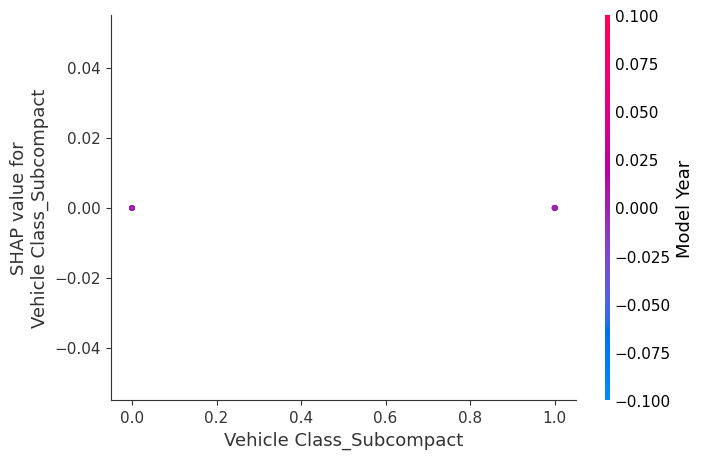

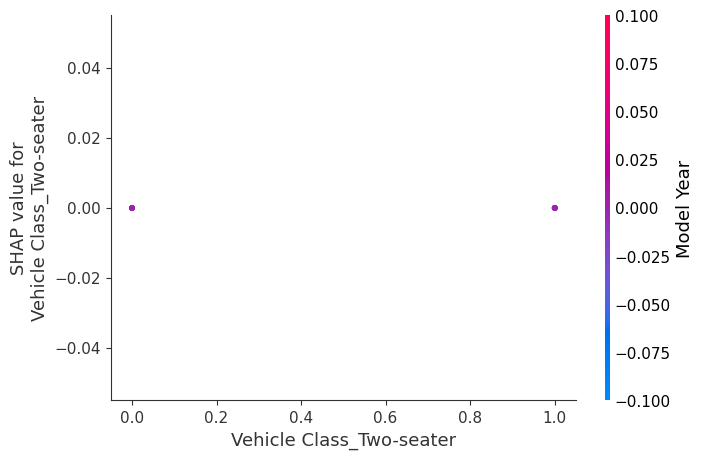

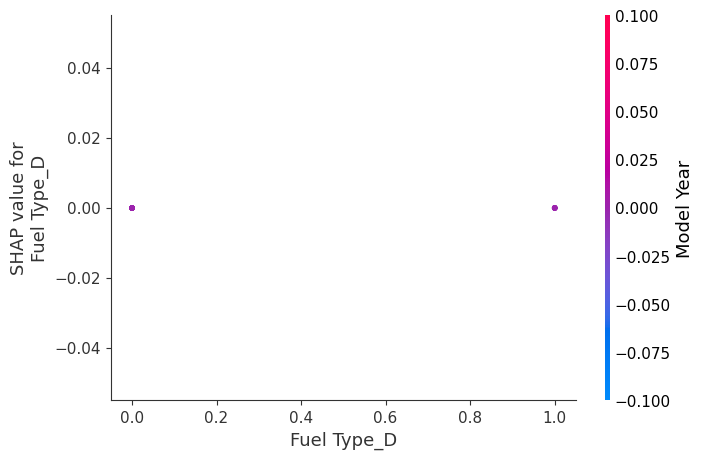

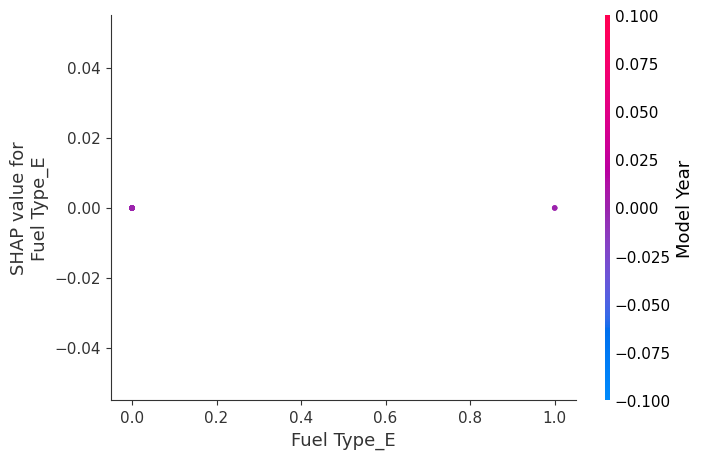

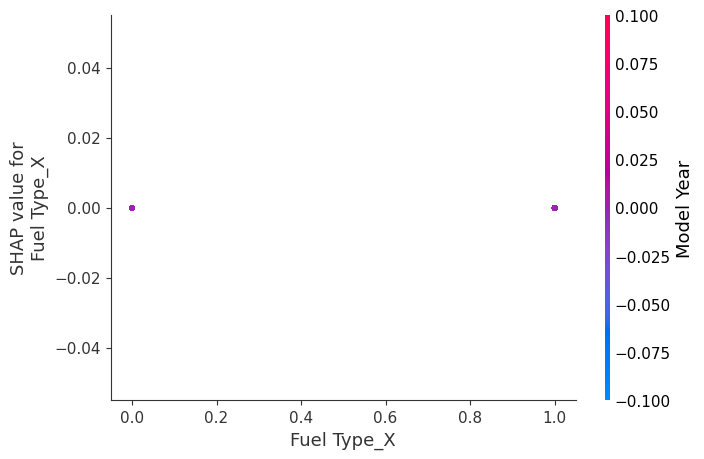

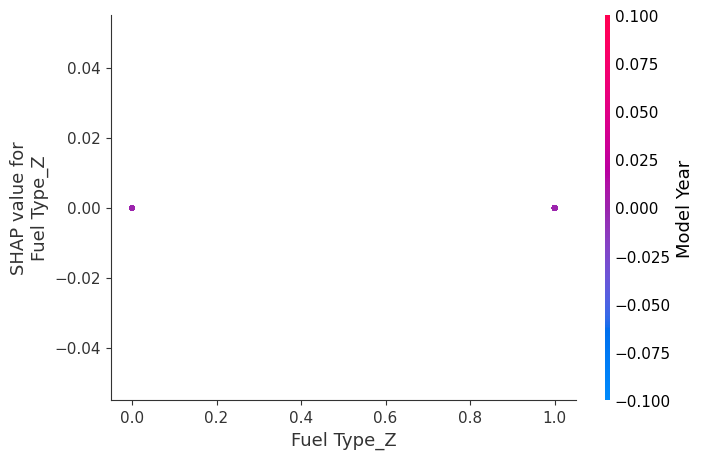

In [92]:
for i in x_train.columns:
  shap.dependence_plot(i, shap_values_decision_tree.values, x_train)

# Heatmap of the SHAP analysis for the decision tree

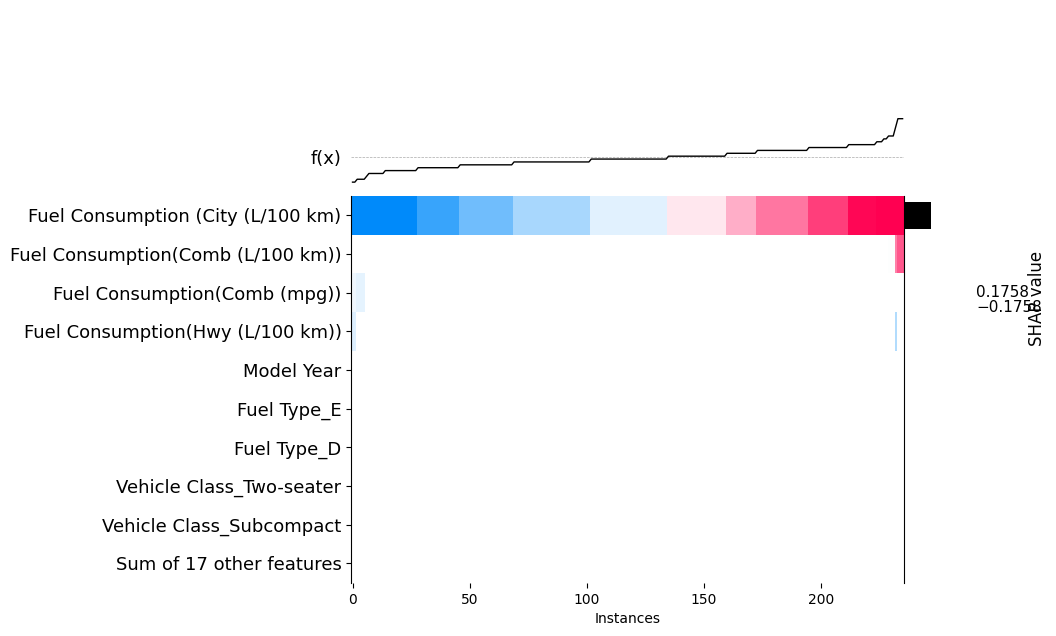

In [93]:
shap.plots.heatmap(shap_values_decision_tree)

# **Auto ML**

In [94]:
try:
  h2o.init()
except:
  print("Unexpected error occured")
  h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         35 mins 02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.3
H2O_cluster_version_age:    5 days
H2O_cluster_name:           H2O_from_python_unknownUser_yr7t5k
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.911 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.9.16 final
--------------------------  -----------------------------------------------------------------------------------------

In [95]:
df = h2o.H2OFrame(data)
df_train, df_test = df.split_frame([0.75])
print(df_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  Model Year    Engine Size(L)    Cylinders    Transmission    Fuel Consumption (City (L/100 km)    Fuel Consumption(Hwy (L/100 km))    Fuel Consumption(Comb (L/100 km))    Fuel Consumption(Comb (mpg))    CO2 Emissions(g/km)    Vehicle Class_Compact    Vehicle Class_Full-size    Vehicle Class_Mid-size    Vehicle Class_Minicompact    Vehicle Class_Minivan    Vehicle Class_Pickup truck: Small    Vehicle Class_Pickup truck: Standard    Vehicle Class_SUV: Small    Vehicle Class_SUV: Standard    Vehicle Class_Special purpose vehicle    Vehicle Class_Station wagon: Mid-size    Vehicle Class_Station wagon: Small    Vehicle Class_Subcompact    Vehicle Class_Two-seater    Fuel Type_D    Fuel Type_E    Fuel Type_X    Fuel Type_Z
           0               2.4            4               7                             0.192308                                 7                                    8.6       

In [96]:
x = df.columns
y = 'CO2 Emissions(g/km)'
x = x.remove(y)
#df_train[y] = df_train[y].asfactor()
#df_test[y] = df_test[y].asfactor()

aml = H2OAutoML(max_runtime_secs=222, balance_classes=True, seed=1) 
aml.train(x = x, y = y, training_frame = df_train)

AutoML progress: |
23:30:14.869: _train param, Dropping bad and constant columns: [Model Year]

█
23:30:17.210: _train param, Dropping bad and constant columns: [Model Year]


23:30:17.761: _train param, Dropping bad and constant columns: [Model Year]

█
23:30:19.261: _train param, Dropping unused columns: [Model Year]
23:30:19.378: _train param, Dropping bad and constant columns: [Model Year]

██
23:30:21.272: _train param, Dropping bad and constant columns: [Model Year]
23:30:22.906: _train param, Dropping bad and constant columns: [Model Year]

██
23:30:25.535: _train param, Dropping bad and constant columns: [Model Year]

███
23:30:29.279: _train param, Dropping bad and constant columns: [Model Year]

█
23:30:32.612: _train param, Dropping unused columns: [Model Year]
23:30:32.746: _train param, Dropping unused columns: [Model Year]

█
23:30:32.876: _train param, Dropping bad and constant columns: [Model Year]


23:30:34.526: _train param, Dropping bad and constant columns: [Model 

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_3_20230409_233014


GLM Model: summary
    family    link      regularization               lambda_search                                                                    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  -------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -------------------------------------------------
    gaussian  identity  Ridge ( lambda = 1.347E-5 )  nlambda = 30, lambda.max = 13.469, lambda.min = 1.347E-5, lambda.1se = 1.458E-4  25                            25                             30                      AutoML_3_20230409_233014_training_py_406_sid_bccb

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 2.0534047272870213e-06
RMSE: 0.0014329705954020903
MAE: 0.0012158143576031107
RMSLE: 0.0010889133416201152
Mean Residual Deviance: 2.0534047272870213e-06
R^2: 0.9998869679985861
Null degrees of freedom: 724
Residual degrees of freedom: 699
Null deviance: 13.17076941627724
Residual deviance: 0.0014887184272830904
AIC: -7383.147319287083

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 3.310621575609603e-06
RMSE: 0.001819511356273877
MAE: 0.0015459460278059972
RMSLE: 0.0013834161796054778
Mean Residual Deviance: 3.310621575609603e-06
R^2: 0.9998177630655845
Null degrees of freedom: 724
Residual degrees of freedom: 699
Null deviance: 13.18685363365012
Residual deviance: 0.002400200642316962
AIC: -7036.860711136836

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.00154595   9.74933e-05  0.00159461    0.00145148    0.00167694    0.00155785    0.00144885
mean_residual_deviance  3.31062e-06  5.61406e-07  3.66981e-06   2.86669e-06   4.09471e-06   3.15495e-06   2.76694e-06
mse                     3.31062e-06  5.61406e-07  3.66981e-06   2.86669e-06   4.09471e-06   3.15495e-06   2.76694e-06
null_deviance           2.63737      0.134922     2.46688       2.61904       2.6938        2.829         2.57813
r2                      0.999817     3.29798e-05  0.999783      0.999841      0.999779      0.999838      0.999844
residual_deviance       0.00048004   8.14039e-05  0.000532122   0.00041567    0.000593733   0.000457468   0.000401207
rmse                    0.0018144    0.000152444  0.00191567    0.00169313    0.00202354    0.00177622    0.00166341
rmsle                   0.00138043   0.000101552  0.00145409    0.00126847    0.00151099    0.00136585    0.00130276

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train          deviance_xval           deviance_se             alpha    iterations    training_rmse          training_deviance       training_mae           training_r2
---  -------------------  ----------  -----------  --------  ------------  ----------------------  ----------------------  ----------------------  -------  ------------  ---------------------  ----------------------  ---------------------  ------------------
     2023-04-09 23:30:17  0.000 sec   1            .13E2     26            0.009159220582987551    0.010308344463496644    0.0002758559757384174   0.0
     2023-04-09 23:30:17  0.001 sec   2            .84E1     26            0.0067391144095542135   0.007889788268526446    0.00022915585153973424  0.0
     2023-04-09 23:30:17  0.002 sec   3            .52E1     26            0.004575087428982262    0.005562415439559839    0.00018069508826565946  0.0
     2023-04-09 23:30:17  0.002 sec   4            .32E1     26      

In [97]:
best_model = aml.leaderboard
print(best_model)

model_id                                                       rmse          mse         mae       rmsle    mean_residual_deviance
GLM_1_AutoML_3_20230409_233014                           0.00181951  3.31062e-06  0.00154595  0.00138342               3.31062e-06
StackedEnsemble_AllModels_2_AutoML_3_20230409_233014     0.00185804  3.45232e-06  0.00158177  0.00141286               3.45232e-06
StackedEnsemble_BestOfFamily_3_AutoML_3_20230409_233014  0.00185854  3.45417e-06  0.00158144  0.00141275               3.45417e-06
StackedEnsemble_BestOfFamily_4_AutoML_3_20230409_233014  0.0018588   3.45513e-06  0.00158271  0.00141422               3.45513e-06
StackedEnsemble_AllModels_1_AutoML_3_20230409_233014     0.00186909  3.4935e-06   0.00159131  0.00142076               3.4935e-06
StackedEnsemble_BestOfFamily_1_AutoML_3_20230409_233014  0.00187324  3.50901e-06  0.00159099  0.00142223               3.50901e-06
StackedEnsemble_BestOfFamily_2_AutoML_3_20230409_233014  0.00187616  3.51999e-06  0.

In [98]:
model_imp = aml.leader
model_imp.model_performance(df_test)

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 2.233742610999768e-06
RMSE: 0.0014945710458187554
MAE: 0.0012975404277037444
RMSLE: 0.001160094049926203
Mean Residual Deviance: 2.233742610999768e-06
R^2: 0.9998601829884847
Null degrees of freedom: 220
Residual degrees of freedom: 195
Null deviance: 3.589079293435127
Residual deviance: 0.0004936571170309487
AIC: -2194.44405764301

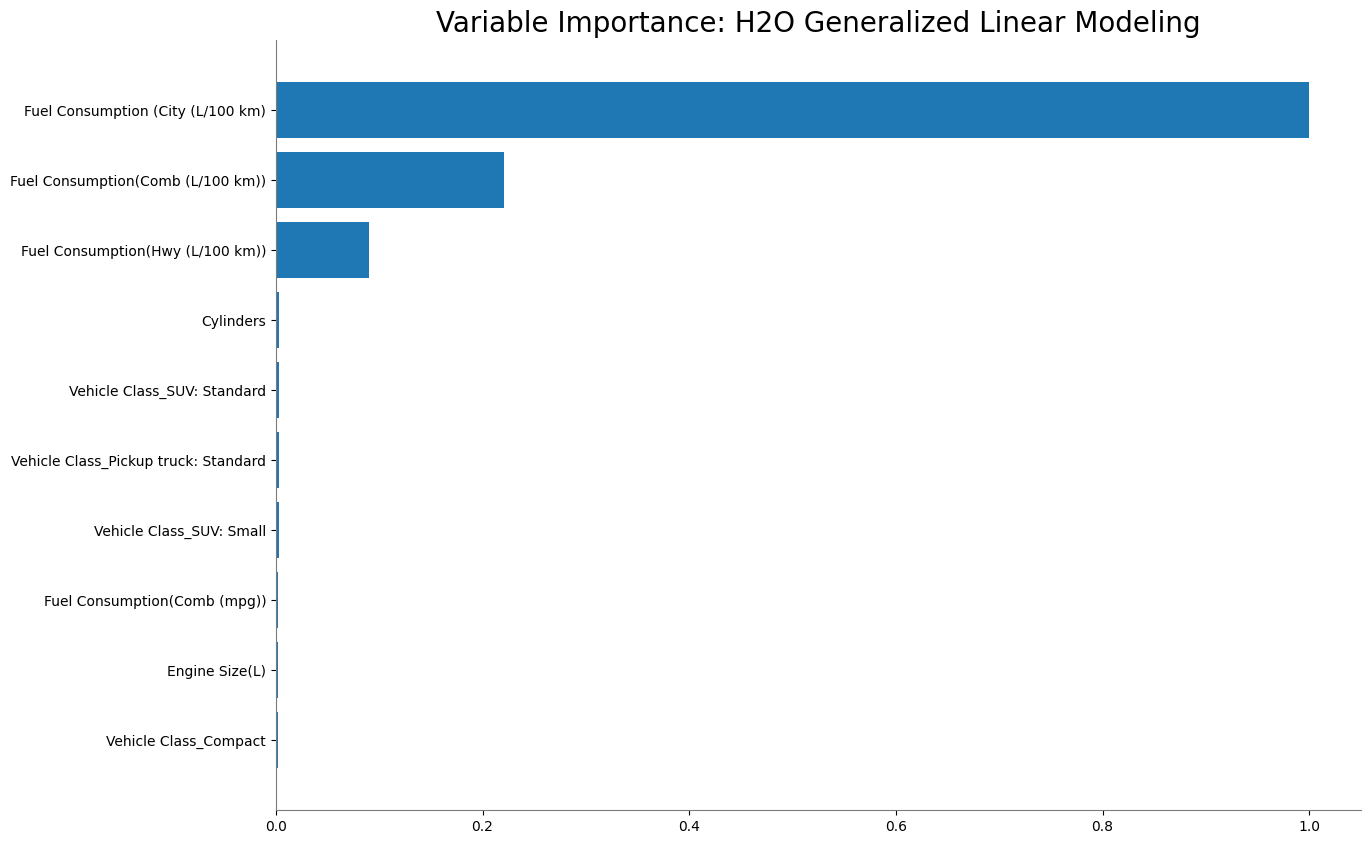

<Figure size 640x480 with 0 Axes>

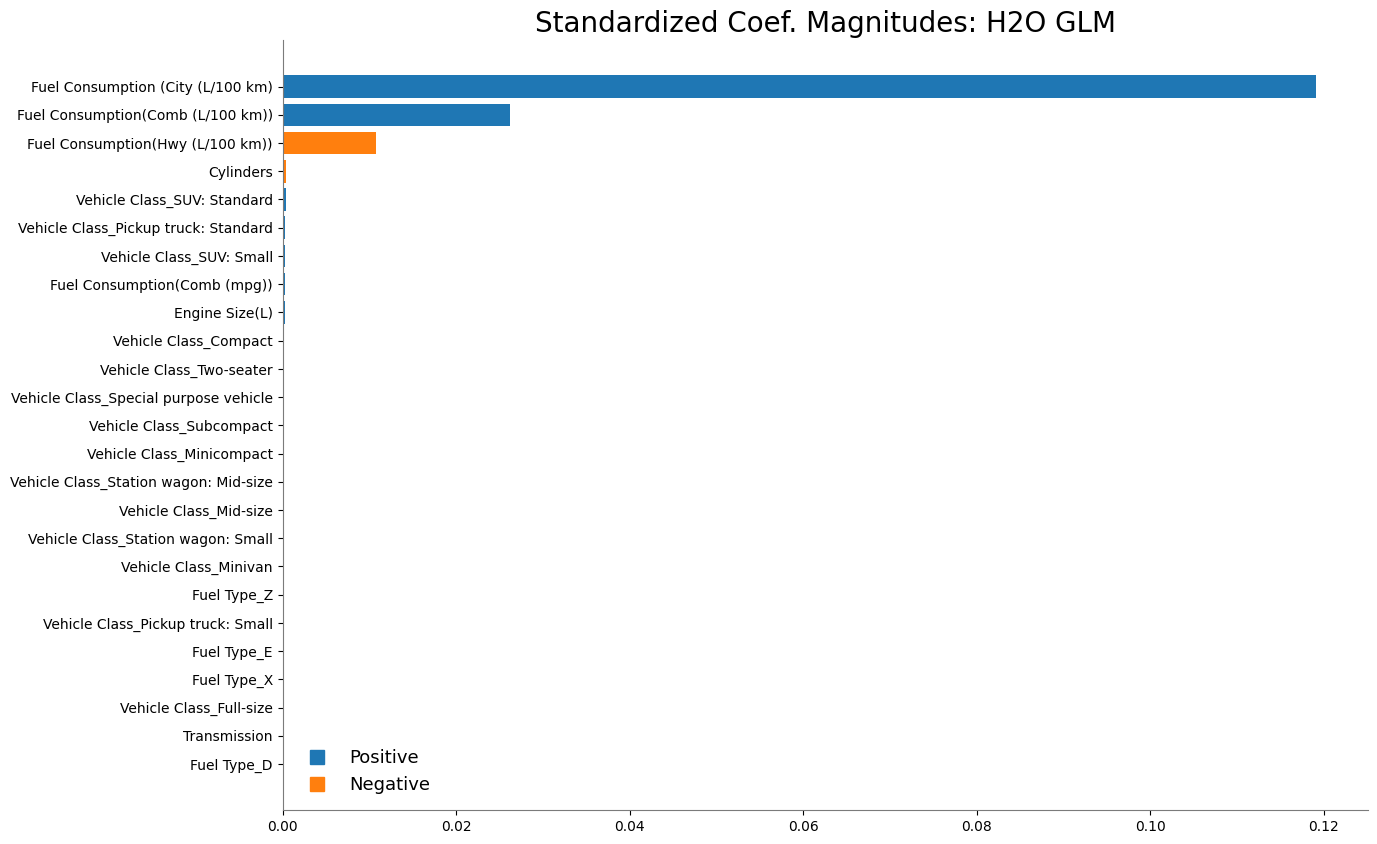

In [99]:
model = aml.get_best_model(algorithm='glm')
model.varimp_plot()
model.std_coef_plot()

Shap analysis (For autoML)
Now to perform better analysis, I can't use our leaderboard's top performer i.e. Stacked ensemble. This is becuase the ensemble is a collection of different models predicting different values and finally making a decision based on the value.

Thus I will be using GLM or Generalized Linear Model.

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

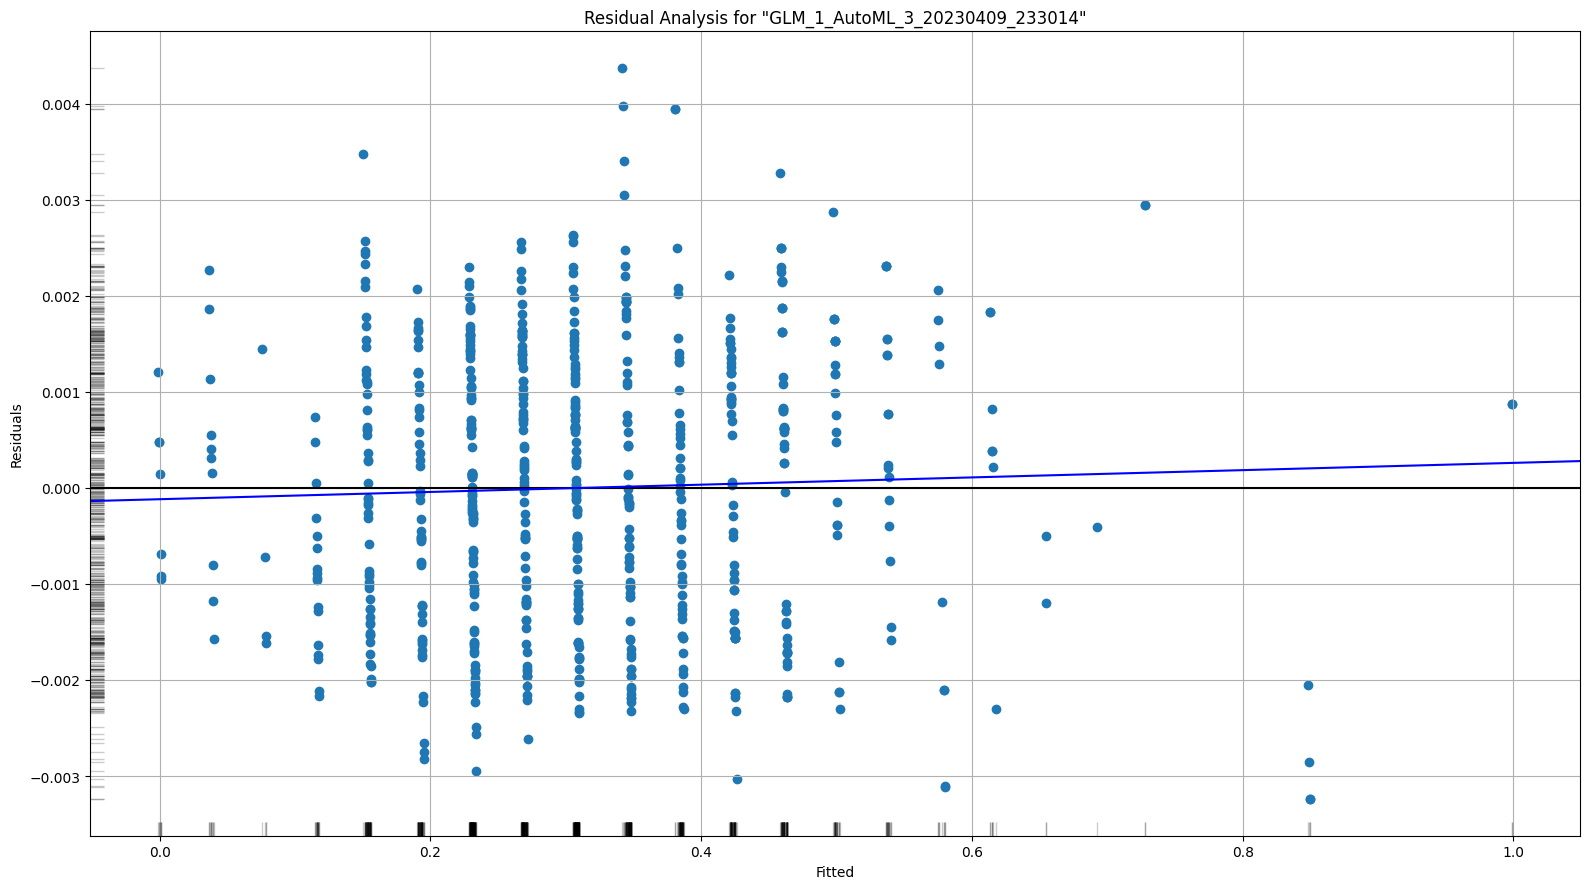

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

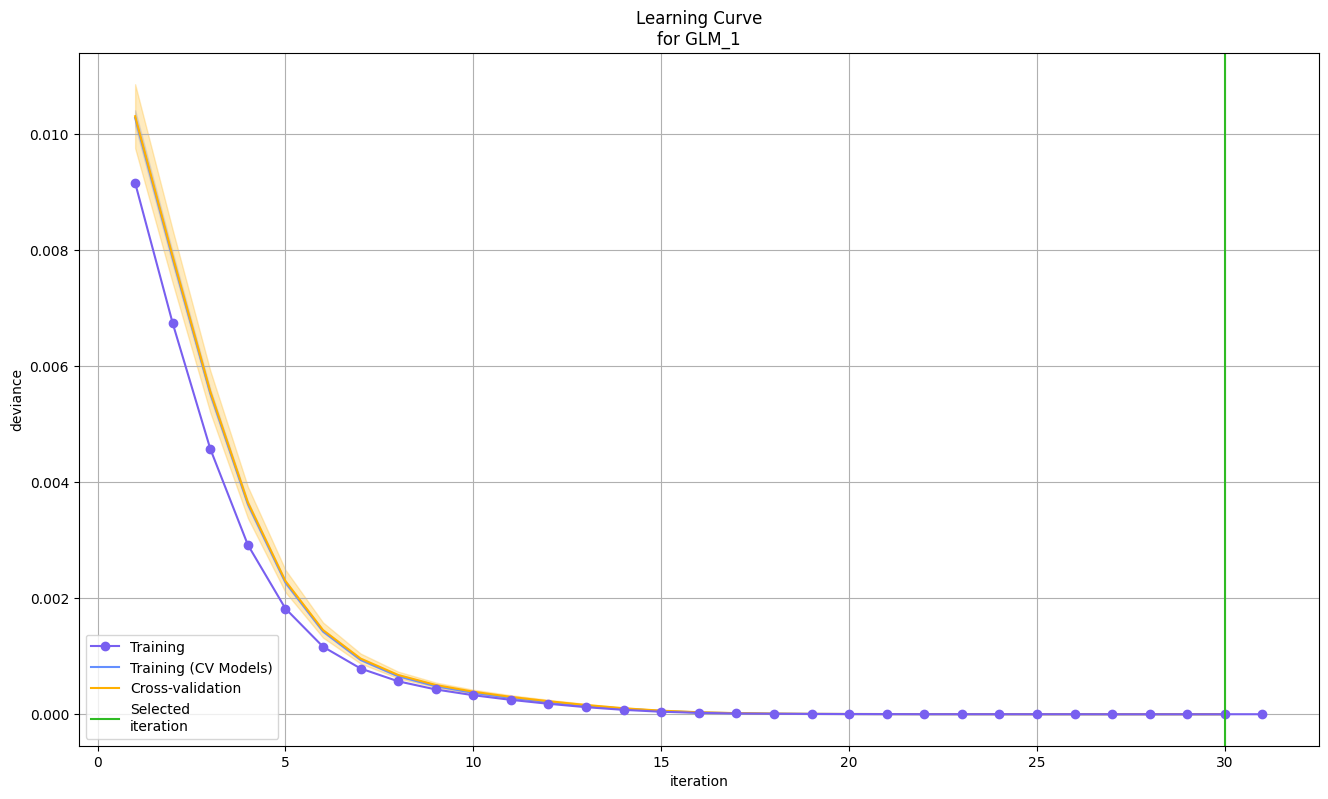

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

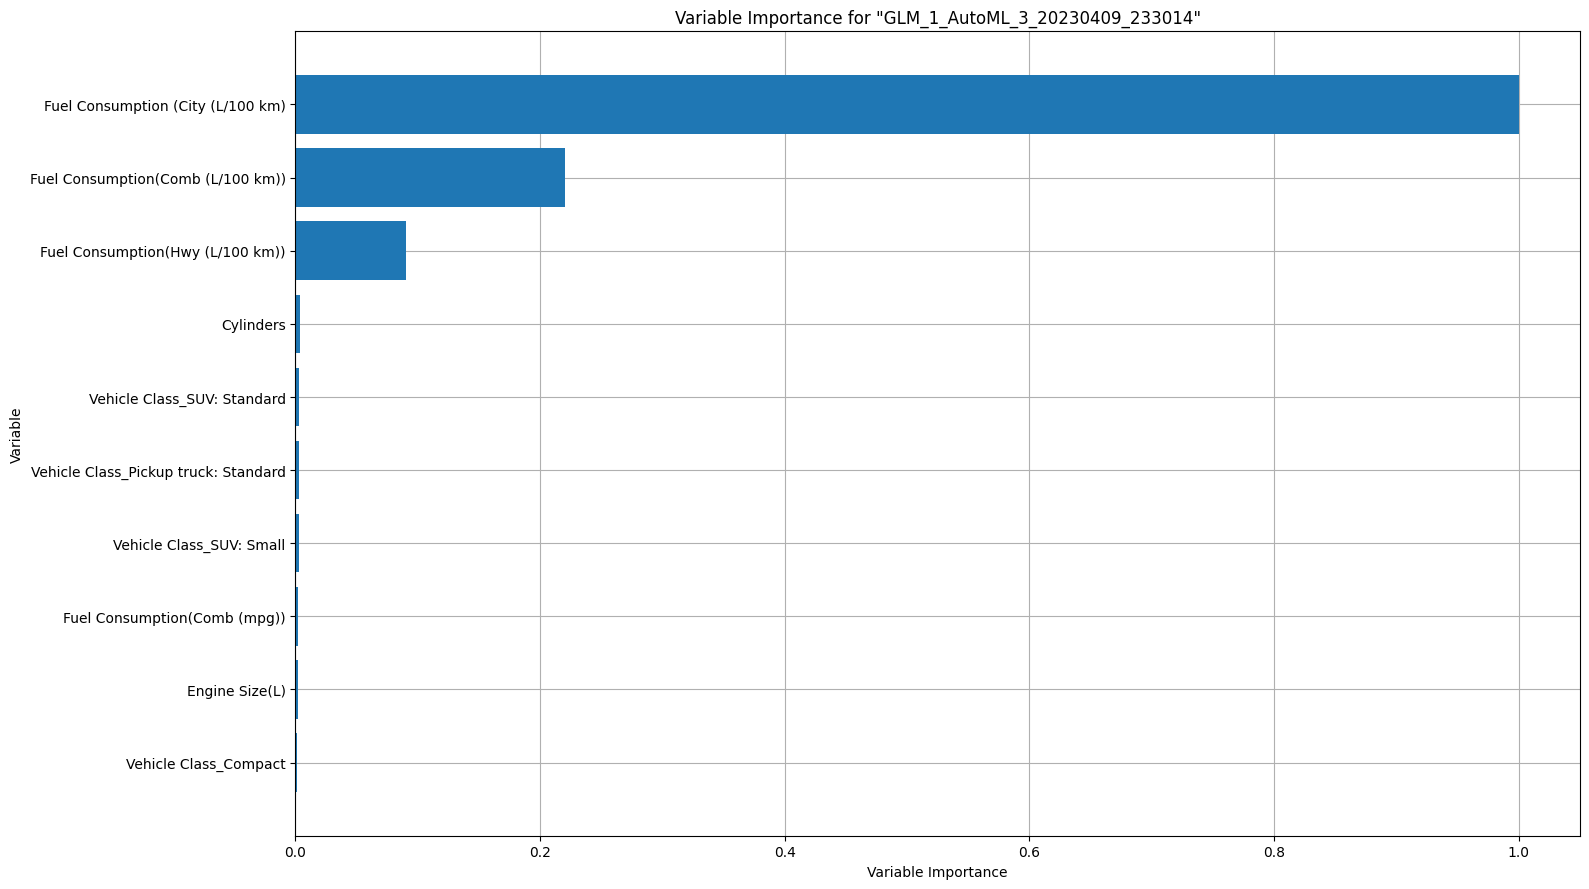

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

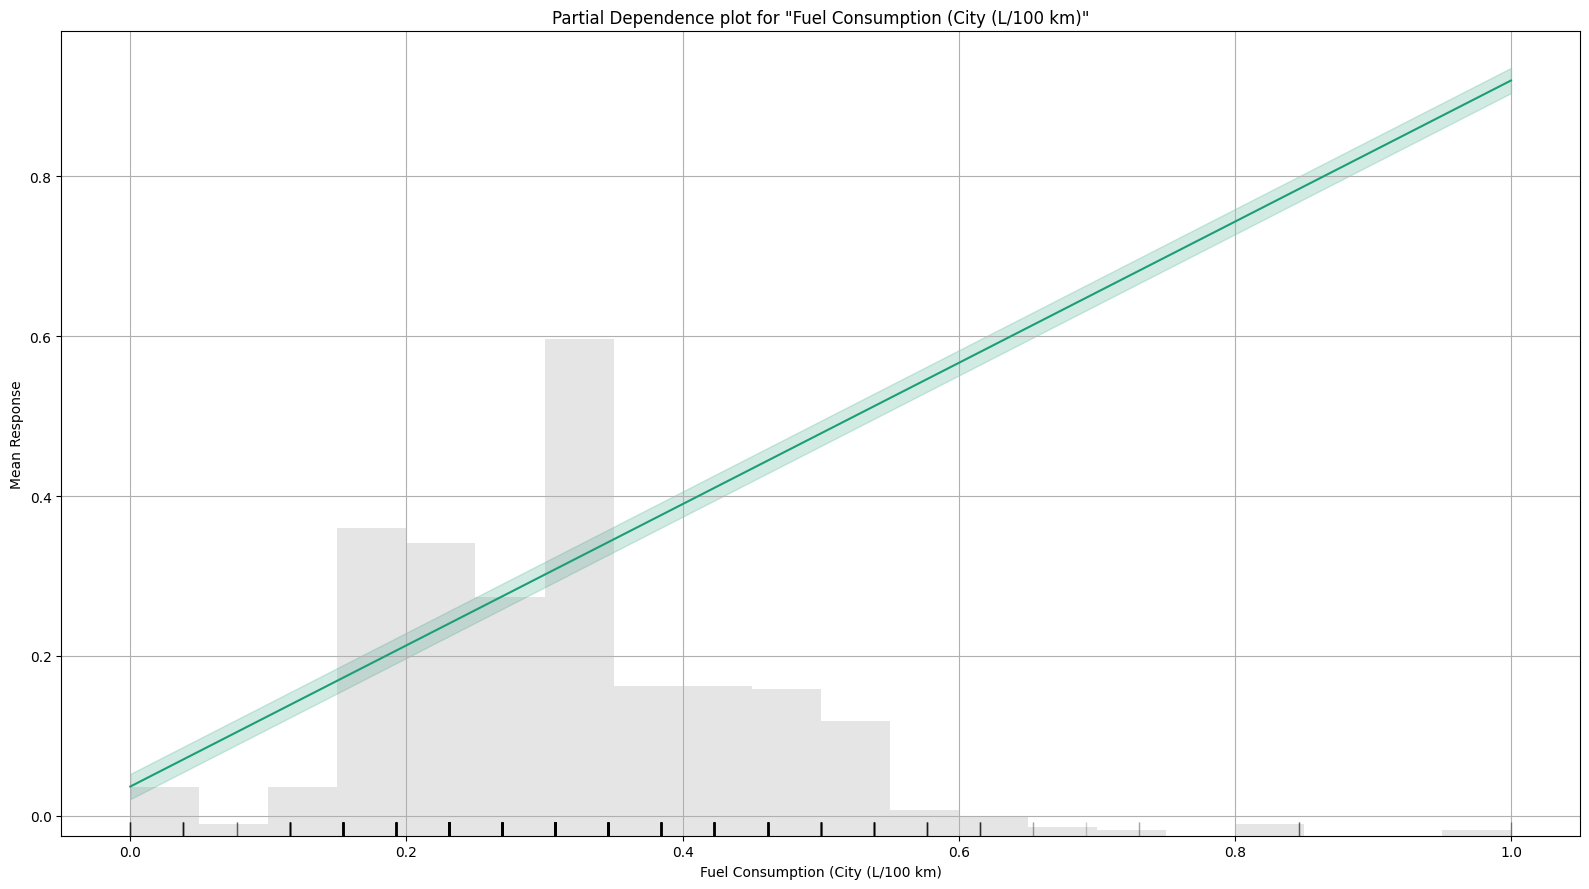

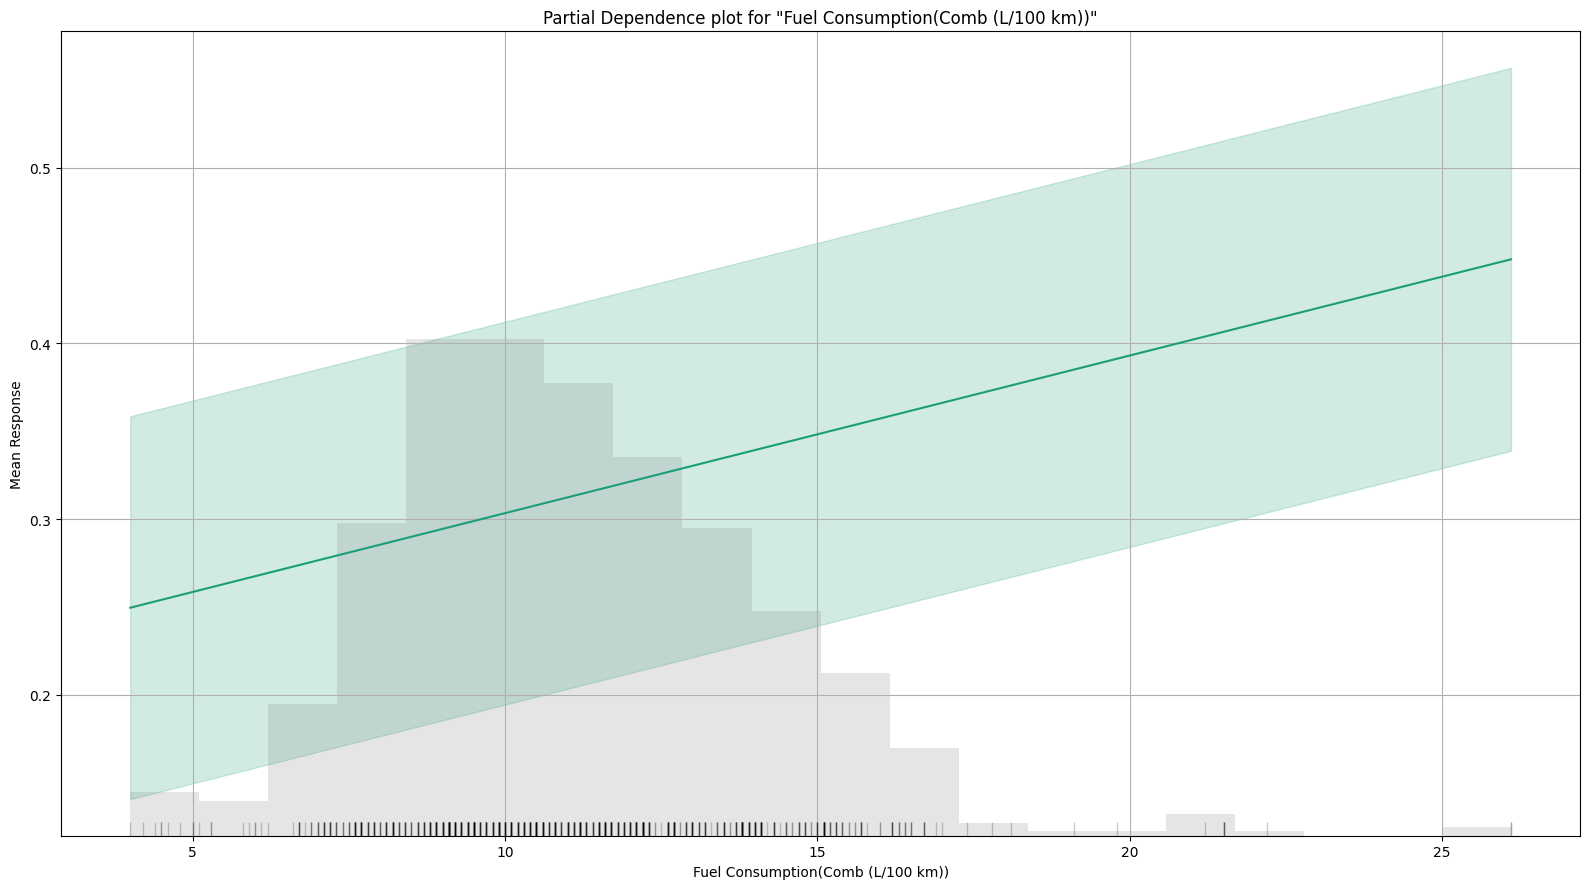

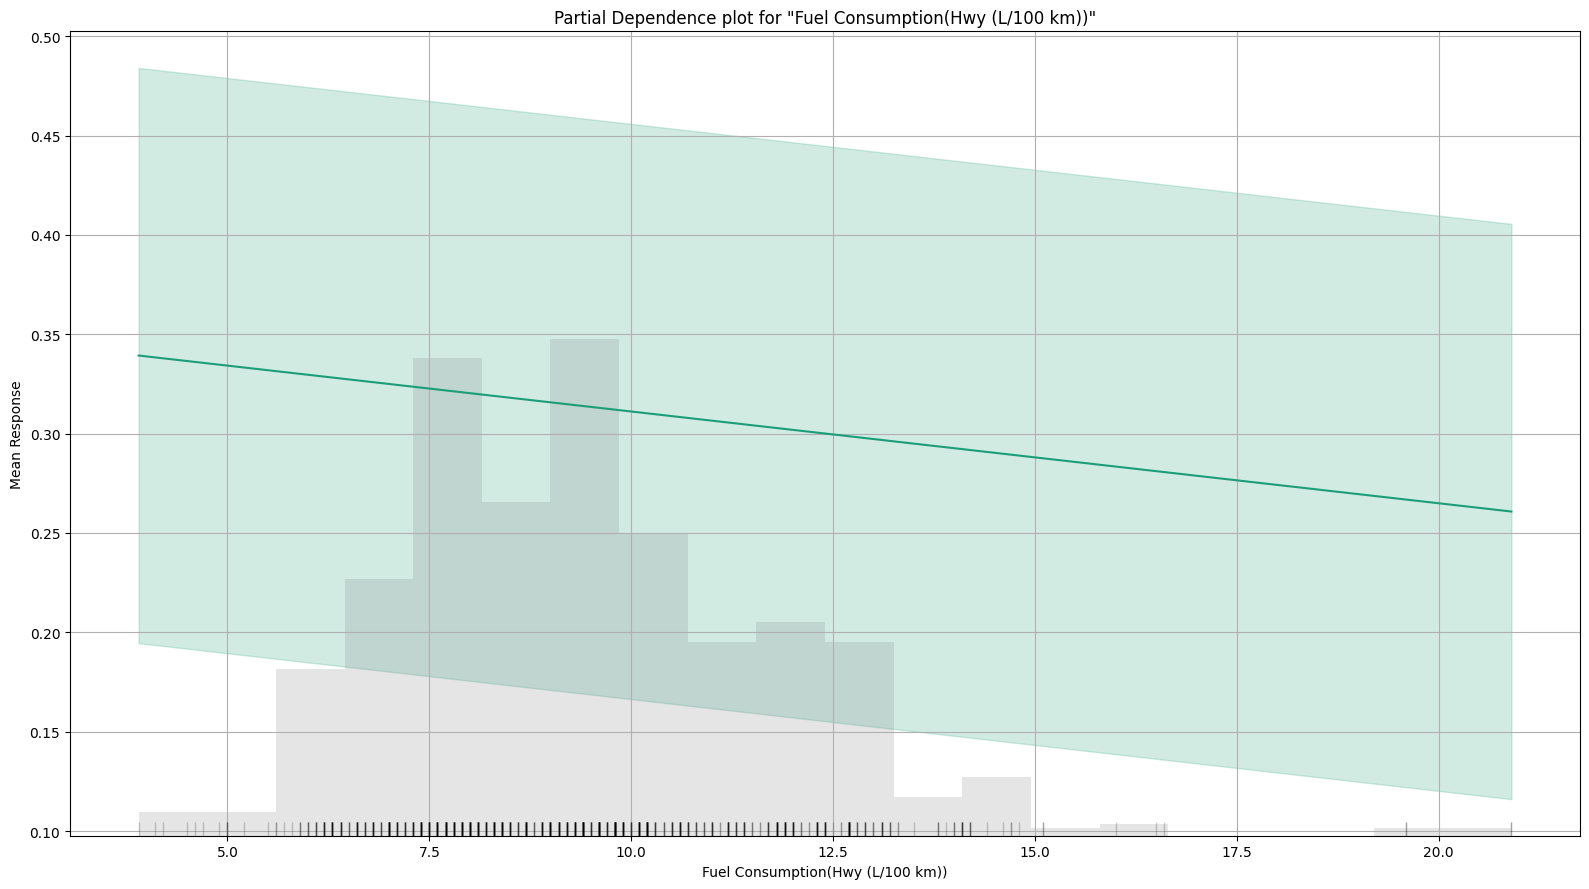

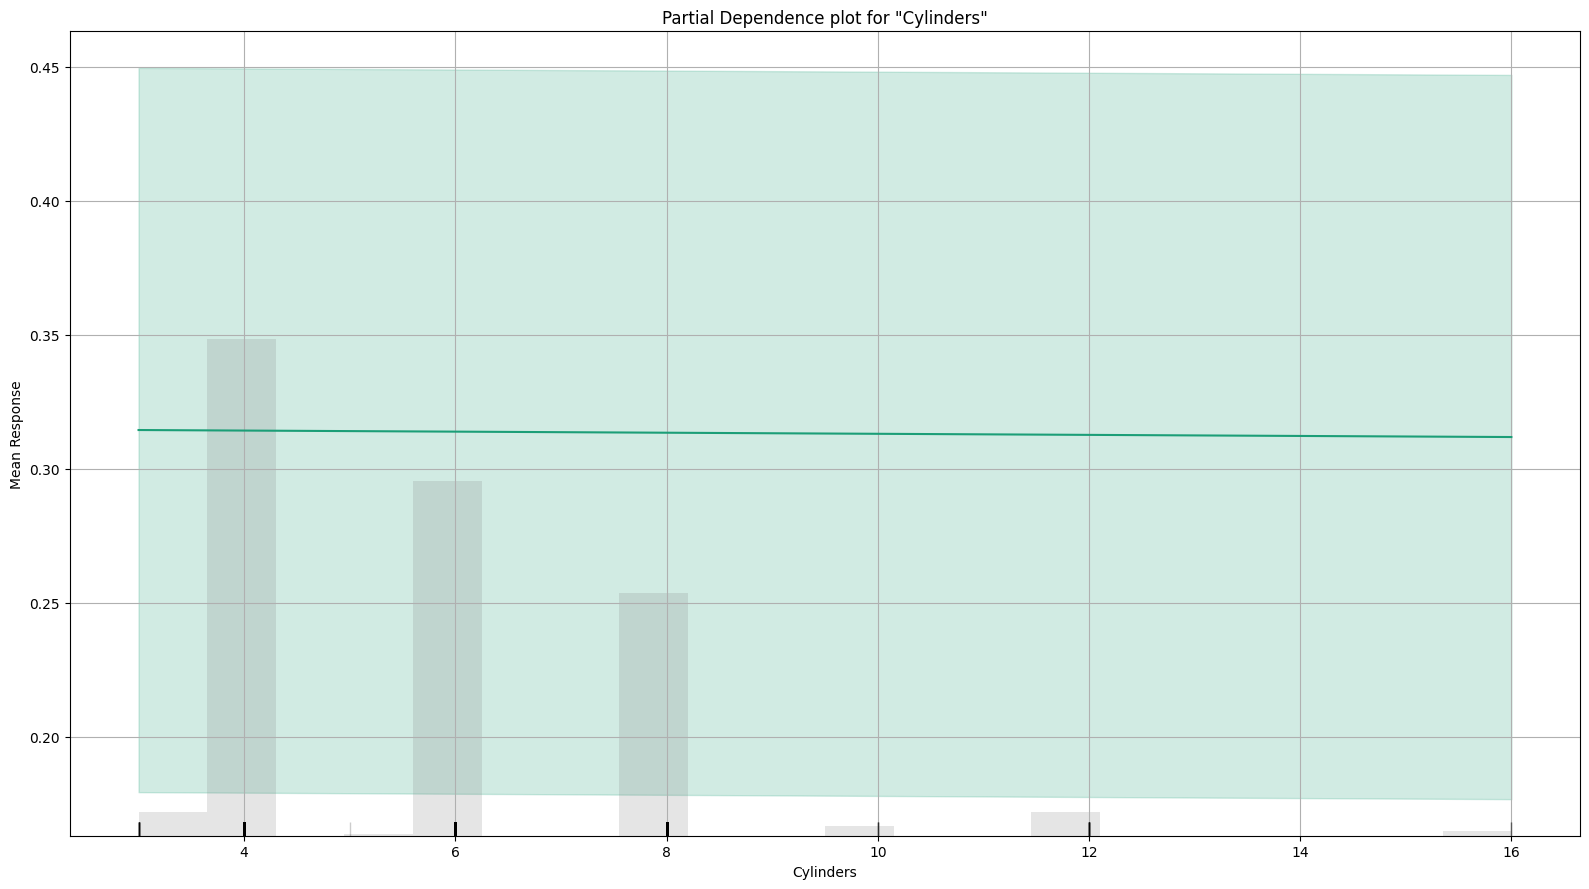

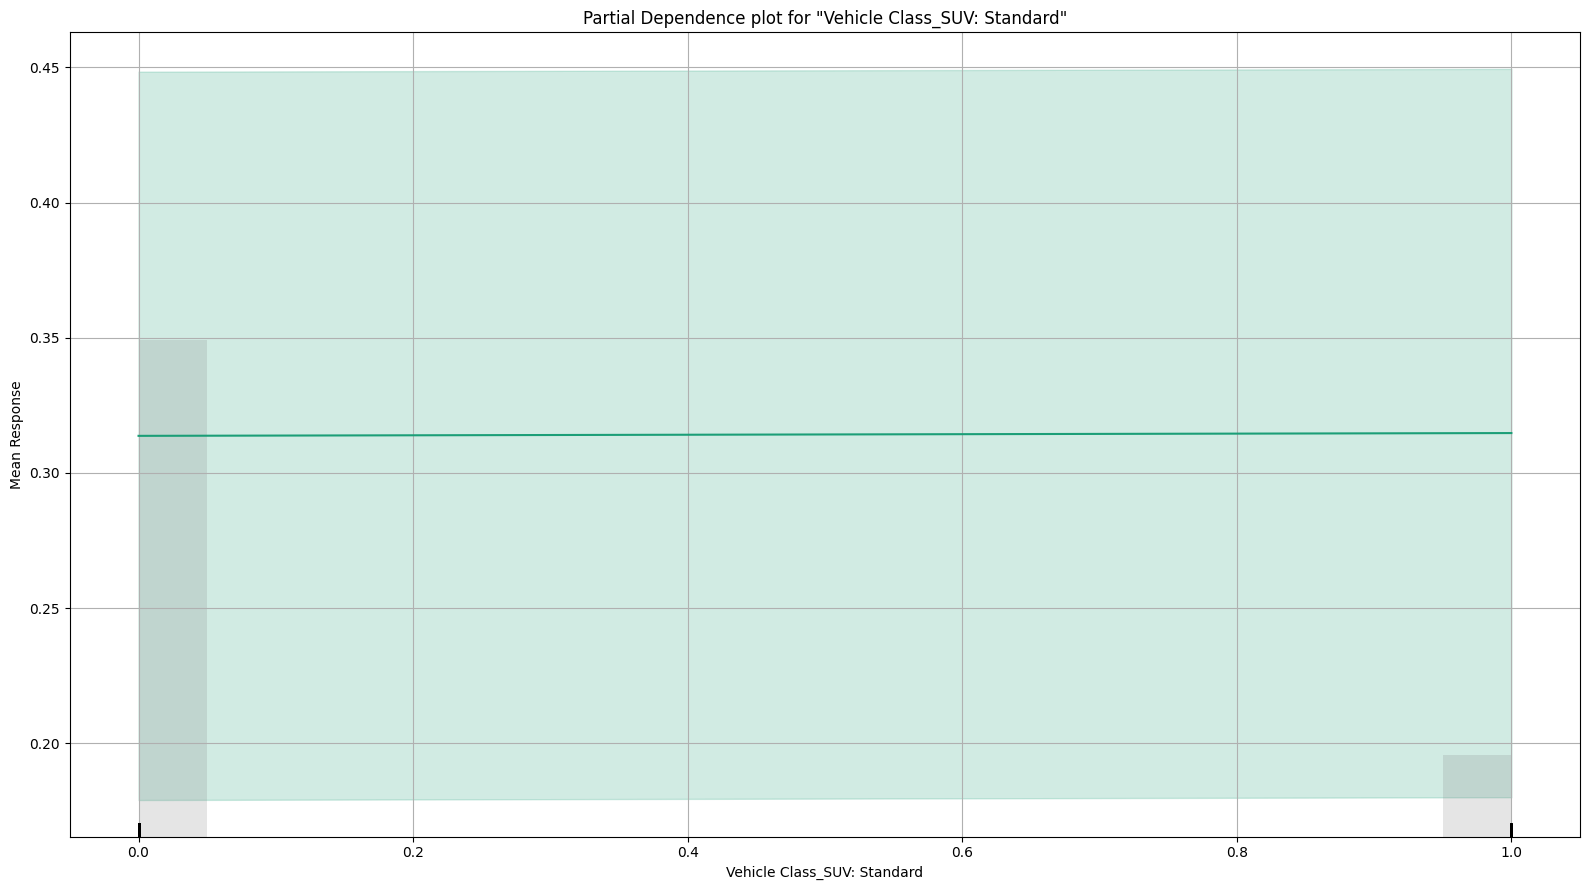

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

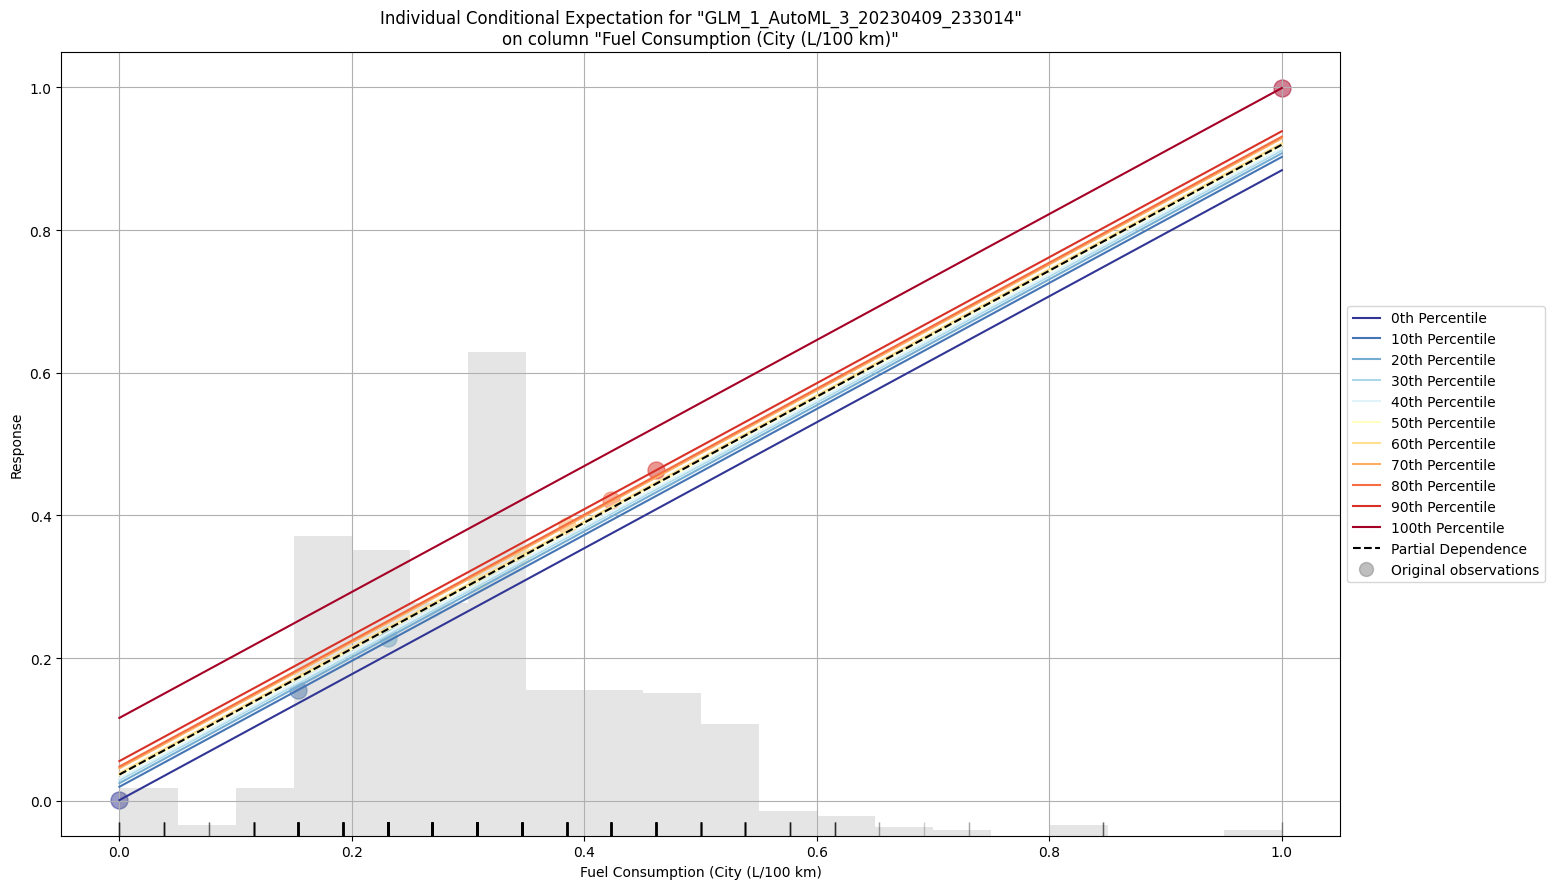

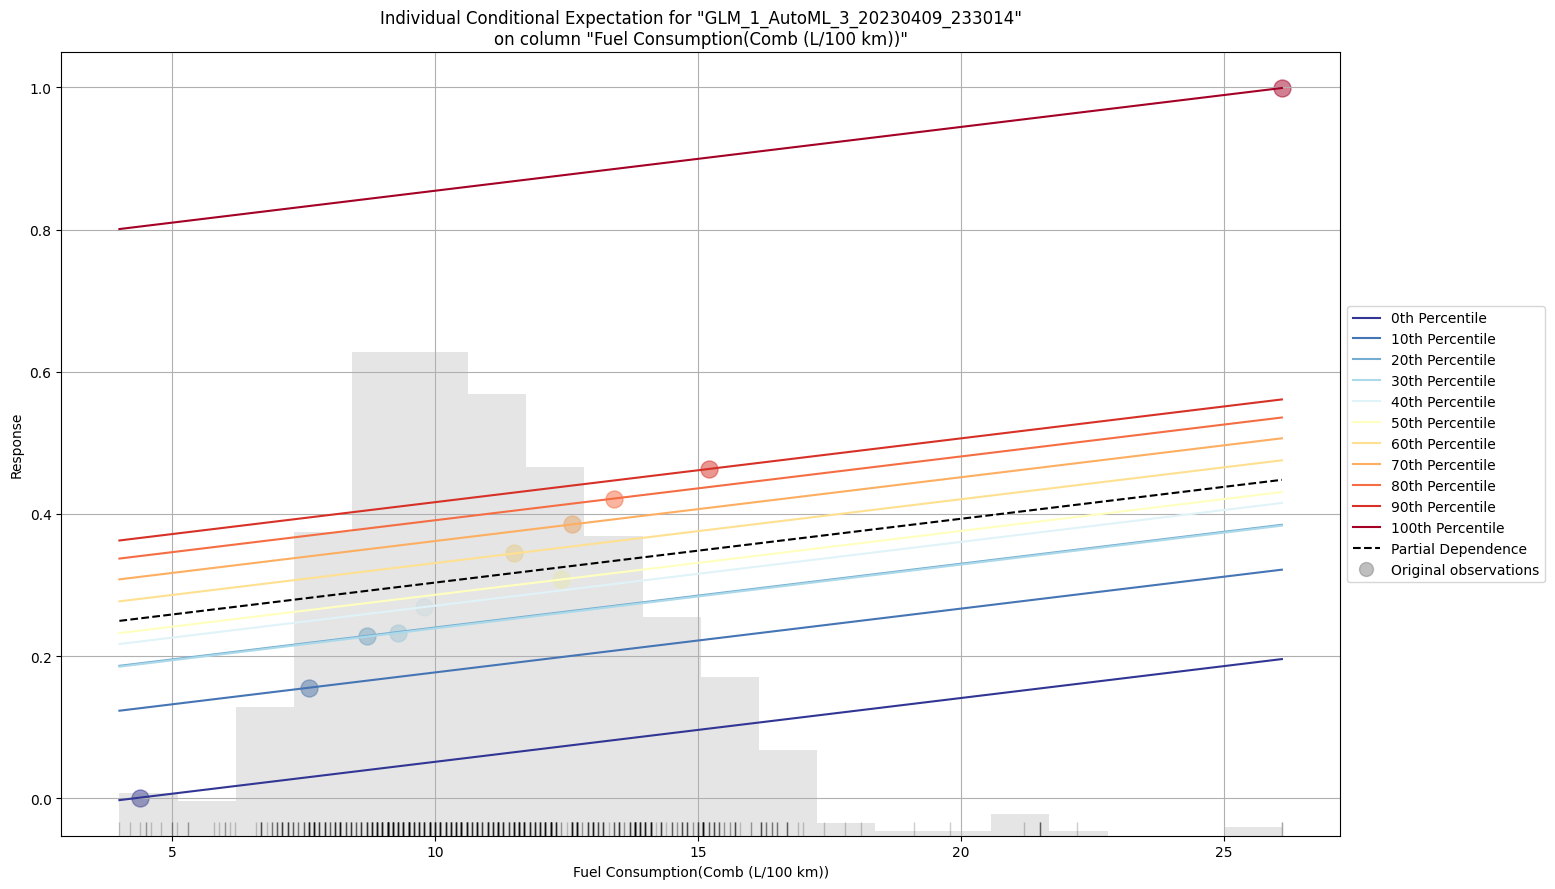

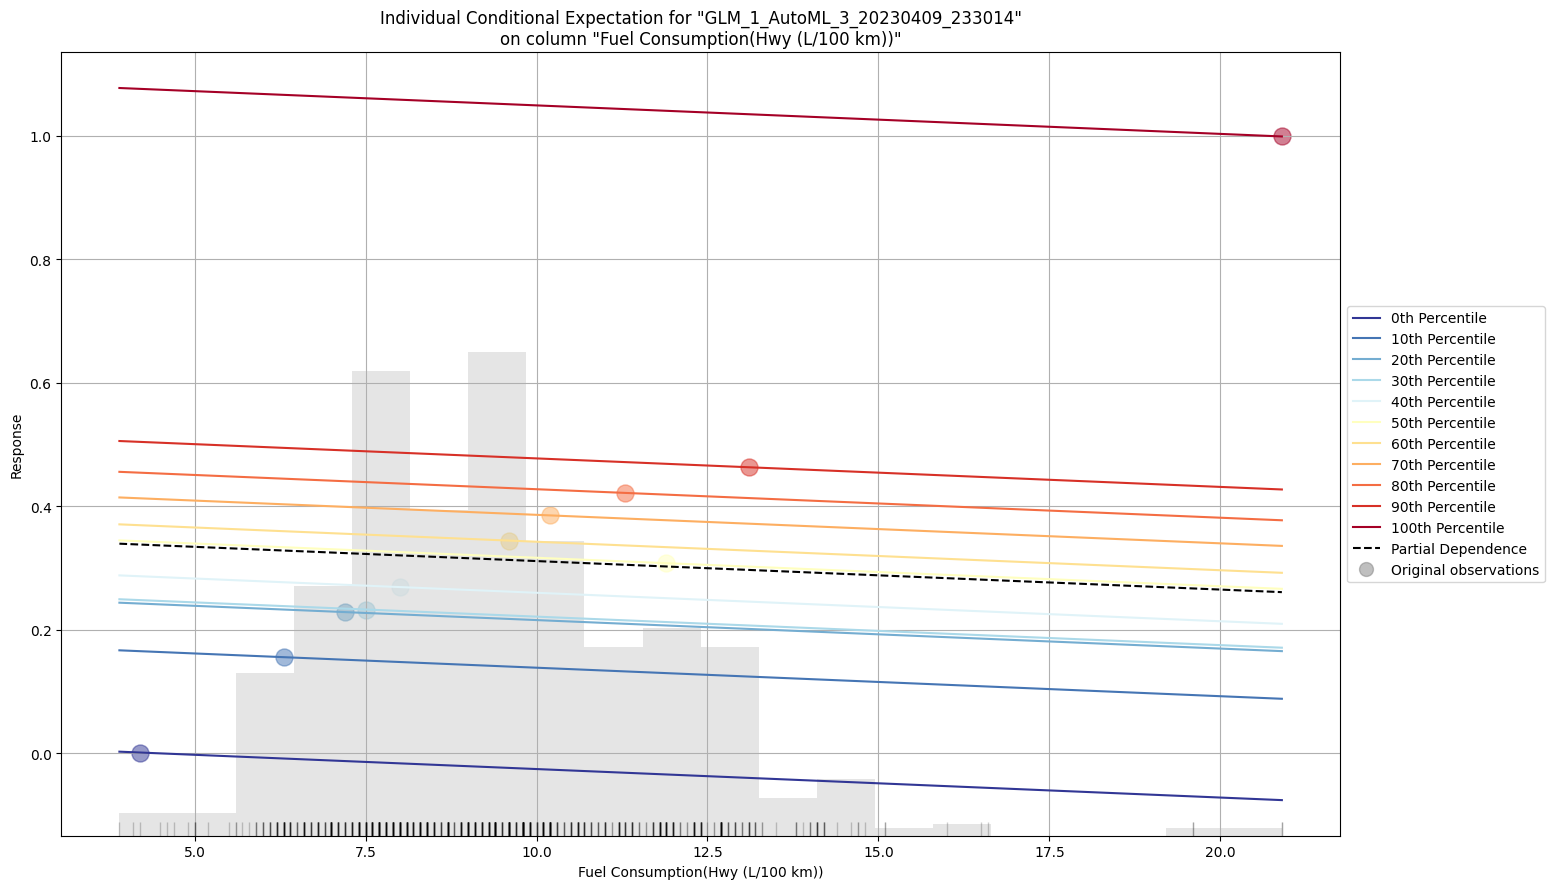

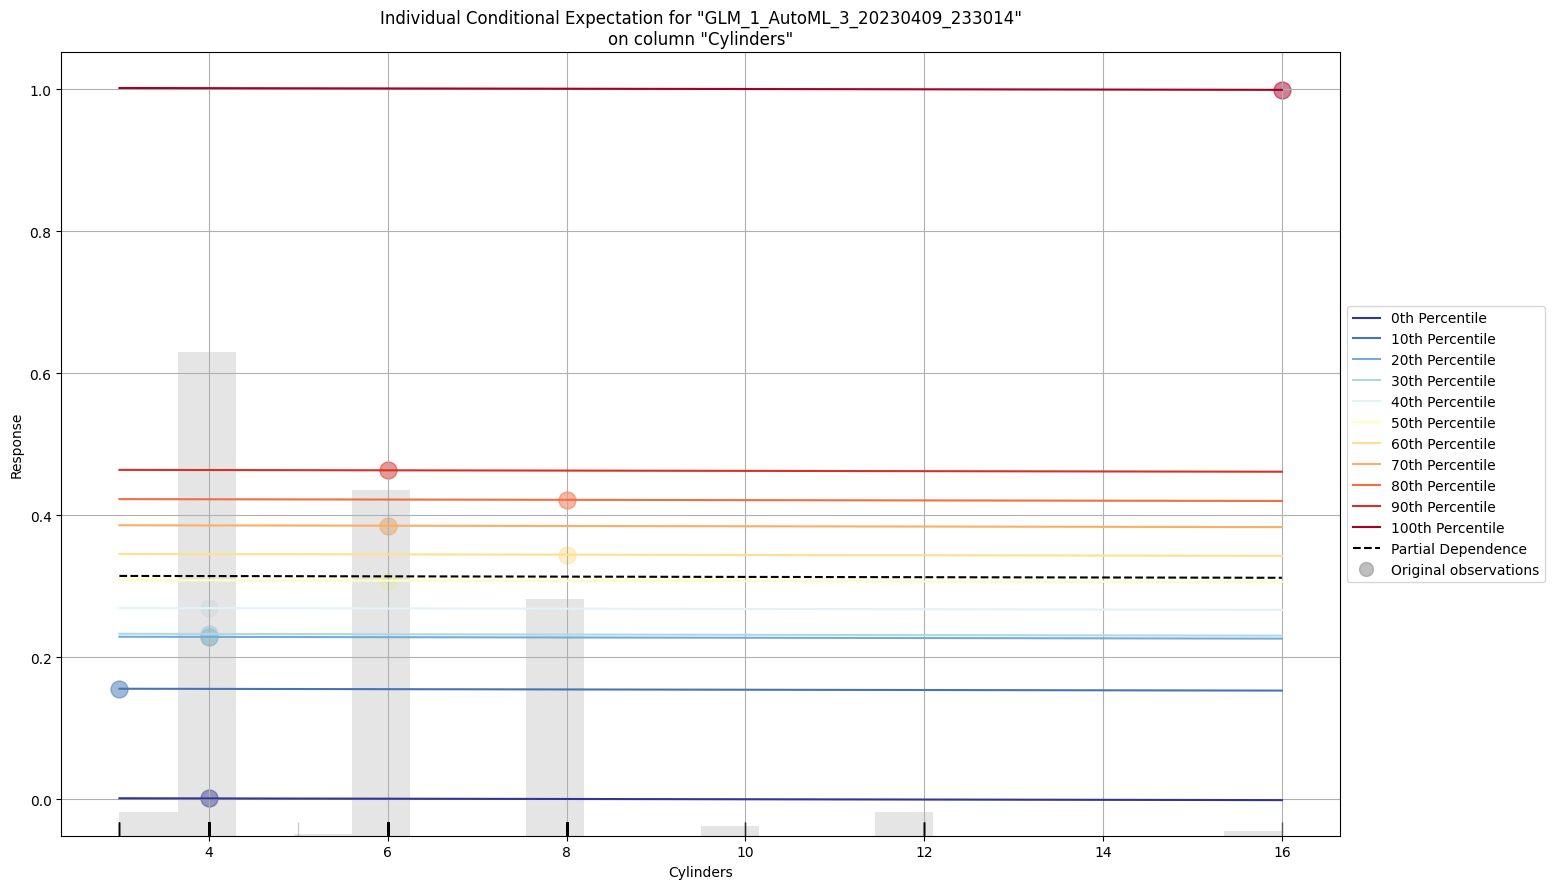

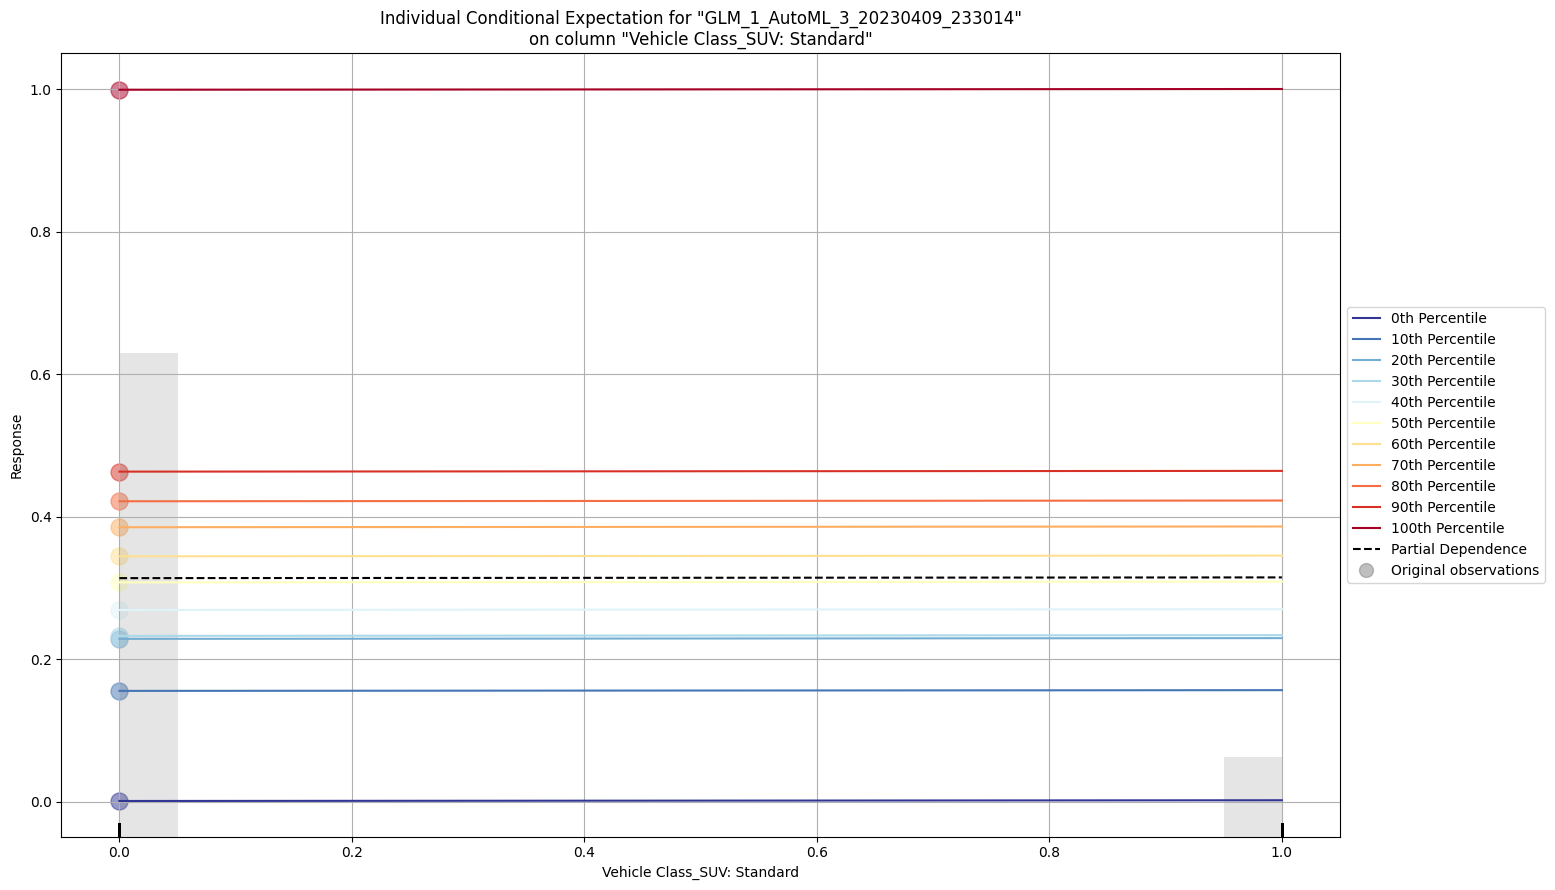

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [100]:
model.explain(df_train)

# **Hyperparamer Tuning**
A low residual deviance indicates that the model fits the data well and explains most of the variation in the response variable. It suggests that the model's predictions closely match the actual values in the data. Residual deviance is lowest at 0.0000490 for

learn_rate : 0.1

max_depth : 9.0

sample_rate : 1. 0

col_sample_rate :0.5

In [101]:
from h2o.grid.grid_search import H2OGridSearch
glm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 30, "seed": 1}
glm_grid = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid_search",
    hyper_params=glm_parameters,
    search_criteria=search_criteria,
)

glm_grid.train(x=x, y=y, training_frame=df_train, ntrees=100, seed=1)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids                 residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------------  ---------------------
     0.5                  0.1           9.0          1.0                 gbm_grid_search_model_67  4.899580902614067e-05
     0.9                  0.1           4.0          0.7000000000000001  gbm_grid_search_model_75  5.993306429455564e-05
     0.6000000000000001   0.1           4.0          1.0                 gbm_grid_search_model_82  6.05894973318432e-05
     0.9                  0.07          4.0          0.9                 gbm_grid_search_model_77  6.836166155075403e-05
     0.4                  0.08          6.0          0.9                 gbm_grid_search_model_88  6.95792550214012e-05
     0.9                  0.09          9.0          0.6000000000000001  gbm_grid_search_model_63  7.137630872510936e-05
     0.6000000000000001   0.09          3.0          0.9                 gbm_grid_search_model_78  7.537887809732197e-05
     0.6000000000000001   0.09          3.0          0.8                 gbm_grid_search_model_61  7.941720038640746e-05
     0.5                  0.05          7.0          0.9                 gbm_grid_search_model_62  9.206603054837306e-05
     0.8                  0.06          9.0          0.6000000000000001  gbm_grid_search_model_90  9.737101295283416e-05
---  ---                  ---           ---          ---                 ---                       ---
     0.30000000000000004  0.02          2.0          1.0                 gbm_grid_search_model_20  375.97169582521053
     0.30000000000000004  0.02          2.0          1.0                 gbm_grid_search_model_50  384.5493512375718
     0.5                  0.01          10.0         1.0                 gbm_grid_search_model_24  653.2734341375991
     0.6000000000000001   0.01          9.0          0.8                 gbm_grid_search_model_11  659.5775792708936
     0.5                  0.01          10.0         1.0                 gbm_grid_search_model_54  660.2756107784722
     0.6000000000000001   0.01          9.0          0.8                 gbm_grid_search_model_41  673.2381240749395
     1.0                  0.01          2.0          0.5                 gbm_grid_search_model_53  884.1532149635648
     1.0                  0.01          2.0          0.7000000000000001  gbm_grid_search_model_10  887.1170551831412
     1.0                  0.01          2.0          0.5                 gbm_grid_search_model_23  887.6050116181669
     1.0                  0.01          2.0          0.7000000000000001  gbm_grid_search_model_40  887.7148985991465
[90 rows x 7 columns]

In [102]:
gbm_gridperf2 = glm_grid.get_grid(sort_by="residual_deviance", decreasing = False)
print(gbm_gridperf2)

Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids                 residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------------  ---------------------
     0.5                  0.1           9.0          1.0                 gbm_grid_search_model_67  4.899580902614067e-05
     0.9                  0.1           4.0          0.7000000000000001  gbm_grid_search_model_75  5.993306429455564e-05
     0.6000000000000001   0.1           4.0          1.0                 gbm_grid_search_model_82  6.05894973318432e-05
     0.9                  0.07          4.0          0.9                 gbm_grid_search_model_77  6.836166155075403e-05
     0.4                  0.08          6.0          0.9                 gbm_grid_search_model_88  6.95792550214012e-05
     0.9                  0.09          9.0          0.6000000000000001  gbm_grid_searc

# **What did you do?**
For this task, I carried out four primary steps.

Initially, I executed data cleaning and normalization to avoid overfitting. I employed a correlation matrix to detect multicollinearity and scaled the data accordingly.

Next, I referred to the same correlation matrix to select features that exhibited a significant positive or negative association with my target variable, i.e., CO2 emissions.

In the third step, I applied various models, such as linear classifier model, decision tree, and autoML, to identify the best-performing model.

To further improve performance, I optimized the hyperparameters using grid search, a functionality provided by H2O.

Finally, I employed interpretability to comprehend the model's predictions based on the input. I used SHAP analysis to ascertain the importance of input variables and their corresponding outputs. To achieve this, I employed SHAP Summary, SHAP Waterfall, and SHAP Dependence Plot. Consequently, I determined the extent of positive or negative influence of different variables.

# **What did you learn?**
Got insights into a range of subjects, including data cleaning, feature selection, assessing variable significance, diverse modeling techniques, evaluation of model performance metrics and results, performance enhancement through optimization, and understanding a model's output in relation to the input provided.



# **How well did it work?**
Based on the information provided, I employed the OLS summary to evaluate the validity of the null hypothesis. Observing a significant relationship, I managed to make attrition predictions using the input variables. To assess the efficacy of our model, I utilized the Root Mean Squared Error metric and executed tests through three distinct methodologies:

Linear regression

Decision tree

AutoML

# **References:**
1) https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb 
2)https://acerta.ai/blog/understanding-machine-learning-with-shap-analysis/
3)https://towardsdatascience.com/lime-vs-shap-which-is-better-for-explaining-machine-learning-models-d68d8290bb16
4)https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

5)https://www.geeksforgeeks.org/regularization-in-machine-learning/

6)https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568#:~:text=What%20are%20Hyperparameters%3F,initialized%20before%20training%20a%20model.

MIT License Copyright (c) 2023 Ryan Jacobs

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.